In [1]:
import torch
import gc

torch.cuda.empty_cache() 
gc.collect()
torch.cuda.synchronize()

In [4]:
import torch
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
from omegaconf import open_dict

import numpy as np
import pandas as pd

In [2]:
from src.datasets.fbirn_main import load_data as load_fbirn_main
from src.datasets.fbirn_holdout import load_data as load_fbirn_holdout
from src.datasets.fbirn_main_sex import load_data as load_fbirn_main_sex
from src.datasets.fbirn_holdout_sex import load_data as load_fbirn_holdout_sex
from src.datasets.fbirn_roi import load_data as load_fbirn_sch

from src.datasets.Nets2_main import load_data as load_2nets_main
from src.datasets.Nets2_holdout import load_data as load_2nets_holdout
from src.datasets.Nets4_main import load_data as load_4nets_main
from src.datasets.Nets4_holdout import load_data as load_4nets_holdout


# models

## old model

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

Logs_Root = "/data/users2/ppopov1/glass_proj/assets/test_logs/old_model/"

class RegCEloss:
    """Cross-entropy loss with model regularization"""

    def __init__(self, model_cfg):
        self.sparsity_loss = InvertedHoyerMeasure(threshold=model_cfg.loss.threshold)

        self.sp_weight = model_cfg.loss.sp_weight
        self.pred_weight = model_cfg.loss.pred_weight


    def __call__(self, logits, target, FNCs, predicted, originals):
        if logits is not None and target is not None: # training case
            ce_loss = F.cross_entropy(logits, target)

            B, T, C, _ = FNCs.shape
            FNCs = FNCs.reshape(B*T, C, C)
            sparse_loss = self.sparsity_loss(FNCs)

            pred_loss = F.mse_loss(predicted, originals)

            loss = ce_loss + self.sp_weight * sparse_loss + self.pred_weight * pred_loss

            loss_components = {
                "ce_loss": ce_loss.item(),
                "sp_loss": sparse_loss.item(),
                "pred_loss": pred_loss.item(),
            }
            return loss, loss_components
        
        else: # pretraining case
            B, T, C, _ = FNCs.shape
            FNCs = FNCs.reshape(B*T, C, C)
            sparse_loss = self.sparsity_loss(FNCs)

            pred_loss = F.mse_loss(predicted, originals)

            loss =  self.sp_weight * sparse_loss + self.pred_weight * pred_loss

            loss_components = {
                "sp_loss": sparse_loss.item(),
                "pred_loss": pred_loss.item(),
            }
            return loss, loss_components

class InvertedHoyerMeasure:
    """Sparsity loss function based on Hoyer measure: https://jmlr.csail.mit.edu/papers/volume5/hoyer04a/hoyer04a.pdf"""
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, x):
        # Assuming x has shape (batch_size, input_dim, input_dim)

        n = x[0].numel()
        sqrt_n = torch.sqrt(torch.tensor(float(n), device=x.device))
        sum_abs_x = torch.sum(torch.abs(x), dim=(1, 2))
        sqrt_sum_squares = torch.sqrt(torch.sum(torch.square(x), dim=(1, 2)))

        numerator = sqrt_n - sum_abs_x / sqrt_sum_squares
        denominator = sqrt_n - 1
        mod_hoyer = 1 - (numerator / denominator) # = 0 if perfectly sparse, 1 if all are equal

        loss = F.leaky_relu(mod_hoyer - self.threshold)
        # Calculate the mean loss over the batch
        mean_loss = torch.mean(loss)

        return mean_loss

class glassDBN(nn.Module):
    def __init__(self, model_cfg):
        super(glassDBN, self).__init__()

        self.input_size = input_size = model_cfg.input_size # n_components (#ROIs/ICs)
        self.num_layers = num_layers = model_cfg.rnn.num_layers # GRU n_layers; won't work with values other than 1
        self.embedding_dim = embedding_dim = model_cfg.rnn.input_embedding_size # embedding size for GRU input
        self.hidden_dim = hidden_dim = model_cfg.rnn.hidden_size # GRU hidden dim
        output_size = model_cfg.output_size # n_classes to predict
        self.single_embed = model_cfg.rnn.single_embed # whether all time series should be embedded with the same vector or not
        
        # Component-specific embeddings
        if model_cfg.rnn.single_embed:
            self.embeddings = nn.Linear(1, embedding_dim)
        else:
            self.embeddings = nn.ModuleList([
                nn.Linear(1, embedding_dim) for _ in range(input_size)
            ])

        # GRU layer
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)

        # Attention layer used to compute the transfer matrices
        self.attention = SelfAttention(
            input_dim=hidden_dim, 
            hidden_dim=model_cfg.attention.hidden_dim,
            n_components=self.input_size
        )

        # Classifier
        self.clf = nn.Sequential(
            nn.Linear(input_size**2, input_size**2 // 2),
            nn.ReLU(),
            nn.Dropout1d(p=0.3),
            nn.Linear(input_size**2 // 2, input_size**2 // 4),
            nn.ReLU(),
            nn.Linear(input_size**2 // 4, output_size),
        )
        # Input predictor
        self.predictor = nn.Linear(hidden_dim, 1)

        self.criterion = RegCEloss(model_cfg)

    def compute_loss(self, additional_outputs, logits, target):
        loss, log = self.criterion(
            logits=logits, 
            target=target, 
            FNCs=additional_outputs["FNCs"], 
            predicted=additional_outputs["predicted"],
            originals=additional_outputs["originals"]
        )

        return loss, log

    
    def save_data(self, cfg, ds_name, data, target, additional_outputs):
        save_path = f"{cfg.run_dir}/data"
        os.makedirs(save_path, exist_ok=True)
        torch.save(data, f"{save_path}/{ds_name}_input.pt")
        torch.save(target, f"{save_path}/{ds_name}_labels.pt")
        torch.save(additional_outputs["FNCs"], f"{save_path}/{ds_name}_FNCs.pt")
        torch.save(additional_outputs["time_logits"], f"{save_path}/{ds_name}_time_logits.pt")

    def forward(self, x, pretraining=False):
        B, T, _ = x.shape  # [batch_size, time_length, input_size]
        orig_x = x

        # Apply component-specific embeddings
        if self.single_embed:
            x = x.permute(0, 2, 1)
            x = x.reshape(B * self.input_size, T, 1)
            embedded = self.embeddings(x).reshape(B, self.input_size, T, self.embedding_dim)
        else:
            embedded = torch.stack([self.embeddings[i](x[:, :, i].unsqueeze(-1)) for i in range(self.input_size)], dim=1)
        # embedded shape: [batch_size, input_size, time_length, embedding_dim]
        
        # Initialize hidden state and run the recurren loop
        h = torch.zeros(B, 1, self.input_size, self.hidden_dim, device=x.device)
        # hidden state shape: [batch_size, 1, input_size, hidden_dim]

        mixing_matrices = []
        hidden_states = []
        for t in range(T):
            # Process one time step
            gru_input = embedded[:, :, t, :].unsqueeze(2)  # (batch_size, input_size, 1, embedding_dim)
            gru_input = gru_input.reshape(B*self.input_size, 1, self.embedding_dim) # (batch_size * input_size, 1, embedding_dim)
            h = h.permute(1, 0, 2, 3).reshape(1, B*self.input_size, self.hidden_dim) # (1, batch_size * input_size, hidden_dim)
            _, h = self.gru(gru_input, h)
            h = h.reshape(1, B, self.input_size, self.hidden_dim).permute(1, 0, 2, 3) # (batch_size, 1, input_size, hidden_dim)

            # Reshape h for self-attention
            h = h.squeeze(1)  # (batch_size, input_size, hidden_dim)
            # Apply self-attention
            h, mixing_matrix = self.attention(h)
            hidden_states.append(h)
            mixing_matrices.append(mixing_matrix)
            h = h.unsqueeze(1) # (batch_size, 1, input_size, hidden_dim)

            if torch.any(torch.isnan(h)):
                raise Exception(f"h has nans at time point {t}")
            
        
        # Stack the alignment matrices, predict the next input 
        mixing_matrices = torch.stack(mixing_matrices, dim=1)  # (batch_size, seq_len, input_size, input_size)
        hidden_states = torch.stack(hidden_states, dim=1)[:, :-1, :, :] # brain latent states starting with time 0, [batch_size; time_length-1; input_size, hidden_dim]
        predicted = self.predictor(hidden_states).squeeze() # predictions of x starting with time 1, [batch_size; time_length-1; input_size]
        
        if pretraining:
            # pretrain on the input prediction task
            return None, {
                "FNCs": mixing_matrices,
                "predicted": predicted,
                "originals": orig_x[:, 1:, :]
            }
        
        clf_input = mixing_matrices.reshape(B, T, -1) # [batch_size; time_length; input_size * input_size]
        time_logits = self.clf(clf_input) # [batch_size; time_length, n_classes]
        logits = torch.mean(time_logits, dim=1) # mean over time, [batch_size; n_classes]
        
        additional_outputs = {
            "FNCs": mixing_matrices,
            "time_logits": time_logits,
            "predicted": predicted,
            "originals": orig_x[:, 1:, :]
        }

        return logits, additional_outputs



class SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_components):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim

        self.gate = Gate(n_components)

        self.query = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.key = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )


    def forward(self, x): # x.shape (batch_size, n_components, GRU hidden size)
        queries = self.query(x)
        keys = self.key(x)

        transfer = torch.bmm(queries, keys.transpose(1, 2))
        norms = torch.linalg.matrix_norm(transfer, keepdim=True)
        transfer = transfer / norms

        gate = self.gate(transfer)
        transfer = transfer * gate

        next_states = torch.bmm(transfer, x)

        return next_states, transfer

class Gate(nn.Module):
    def __init__(self, input_dim):
        super(Gate, self).__init__()
        self.bias = nn.Parameter(torch.randn(input_dim, input_dim))
    
    def forward(self, x):
        # Compute h_ij = abs(x_ij) + b_ij
        h = torch.abs(x) + self.bias
        
        # Compute a_ij = sigmoid(h_ij)
        a = torch.sigmoid(h)
        
        return a
    
from omegaconf import OmegaConf

model_cfg = OmegaConf.create({
    "rnn": {
        "single_embed": True,
        "num_layers": 1,
        "input_embedding_size": 16,
        "hidden_size": 16,
    },
    "attention": {
        "hidden_dim": 16,
    },
    "loss": {
        "threshold": 0.01,
        "sp_weight": 1.0,
        "pred_weight": 1.0,
    },
    "lr": 5e-4,
    "load_pretrained": False,
    "pretrained_path": None,
    "input_size": 53,
    "output_size": 2,
})


In [5]:
model = glassDBN(model_cfg).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {count_parameters(model)}")
print(f"Embedding layer parameters: {count_parameters(model.embeddings)}")
print(f"GRU layer parameters: {count_parameters(model.gru)}")
print(f"Attention layer parameters: {count_parameters(model.attention)}")
print(f"Classifier parameters: {count_parameters(model.clf)}")
print(f"Predictor parameters: {count_parameters(model.predictor)}")

Total parameters: 4939078
Embedding layer parameters: 32
GRU layer parameters: 1632
Attention layer parameters: 4441
Classifier parameters: 4932956
Predictor parameters: 17


## model rewrite

In [26]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from omegaconf import OmegaConf


class InvertedHoyerMeasure:
    """Sparsity loss function based on Hoyer measure: https://jmlr.csail.mit.edu/papers/volume5/hoyer04a/hoyer04a.pdf"""
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, x):
        # Assuming x has shape (batch_size, input_dim, input_dim)

        n = x[0].numel()
        sqrt_n = torch.sqrt(torch.tensor(float(n), device=x.device))
        sum_abs_x = torch.sum(torch.abs(x), dim=(1, 2))
        sqrt_sum_squares = torch.sqrt(torch.sum(torch.square(x), dim=(1, 2)))

        numerator = sqrt_n - sum_abs_x / sqrt_sum_squares
        denominator = sqrt_n - 1
        mod_hoyer = 1 - (numerator / denominator) # = 0 if perfectly sparse, 1 if all are equal

        loss = F.leaky_relu(mod_hoyer - self.threshold)
        # Calculate the mean loss over the batch
        mean_loss = torch.mean(loss)

        return mean_loss

# ## for tests
# loss = InvertedHoyerMeasure(0.1)
# arr = torch.ones(4, 10, 20)
# print(loss(arr)) # should be 0.9 = perfectly dense + threshold

# arr = torch.zeros(4, 10, 20)
# arr[:, 1 , 1] = 1
# print(loss(arr)) # should be -0.0010 = perfectly sparse + thrshold + leakyReLU

class BDMLoss:
    """Cross-entropy, sparsity, and input prediction losses"""

    def __init__(self, model_cfg):
        self.sparsity_loss = InvertedHoyerMeasure(threshold=model_cfg.loss.threshold)

        self.sp_weight = model_cfg.loss.sp_weight
        self.pred_weight = model_cfg.loss.pred_weight


    def __call__(self, logits, target, FNCs, predicted, originals):
        if logits is not None and target is not None: # training case
            ce_loss = F.cross_entropy(logits, target)
            loss = ce_loss
            ce_loss = ce_loss.item()

            if self.sp_weight is not None:
                B, T, C, _ = FNCs.shape
                FNCs = FNCs.reshape(B*T, C, C)
                sparse_loss = self.sparsity_loss(FNCs)
                loss += self.sp_weight * sparse_loss
                sparse_loss = sparse_loss.item()
            else:
                sparse_loss = 0

            if self.pred_weight is not None:
                pred_loss = F.mse_loss(predicted, originals)
                loss += self.pred_weight * pred_loss
                pred_loss = pred_loss.item()
            else:
                pred_loss = 0

            loss_components = {
                "ce_loss": ce_loss,
                "sp_loss": sparse_loss,
                "pred_loss": pred_loss,
            }
            return loss, loss_components
        
        else: # pretraining case
            assert self.pred_weight is not None

            pred_loss = F.mse_loss(predicted, originals)
            loss = self.pred_weight * pred_loss
            pred_loss = pred_loss.item()

            if self.sp_weight is not None:
                B, T, C, _ = FNCs.shape
                FNCs = FNCs.reshape(B*T, C, C)
                sparse_loss = self.sparsity_loss(FNCs)
                loss += self.sp_weight * sparse_loss
                sparse_loss = sparse_loss.item()
            else:
                sparse_loss = 0

            loss_components = {
                "sp_loss": sparse_loss,
                "pred_loss": pred_loss,
            }
            return loss, loss_components



class BrainDynaMo(nn.Module):
    def __init__(self, model_cfg):
        super(BrainDynaMo, self).__init__()

        self.input_size = input_size = model_cfg.input_size # n_components (#ROIs/ICs)
        self.embedding_dim = embedding_dim = model_cfg.rnn.input_embedding_size # embedding size for GRU input
        self.hidden_dim = hidden_dim = model_cfg.rnn.hidden_size # GRU hidden dim
        output_size = model_cfg.output_size # n_classes to predict


        # input embedding vector and GRU block
        self.embeddings = nn.Linear(1, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        # Attention layer used to compute the matrices that mix the GRU hidden states
        self.attention = BilinearAttention(
            input_dim=hidden_dim, 
            hidden_dim=model_cfg.attention.hidden_dim,
            n_components=self.input_size
        )

        # Classifier
        self.clf = nn.Sequential(
            nn.Linear(input_size**2, 32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        )
        # Input predictor
        self.predictor = nn.Linear(hidden_dim, 1)

        self.criterion = BDMLoss(model_cfg)

    def compute_loss(self, additional_outputs, logits=None, target=None):
        loss, log = self.criterion(
            logits=logits, 
            target=target, 
            FNCs=additional_outputs["FNCs"], 
            predicted=additional_outputs["predicted"],
            originals=additional_outputs["originals"]
        )

        return loss, log

    def save_data(self, cfg, ds_name, data, target, additional_outputs):
        save_path = f"{cfg.run_dir}/data"
        os.makedirs(save_path, exist_ok=True)
        torch.save(data, f"{save_path}/{ds_name}_input.pt")
        torch.save(target, f"{save_path}/{ds_name}_labels.pt")
        torch.save(additional_outputs["FNCs"], f"{save_path}/{ds_name}_FNCs.pt")
        torch.save(additional_outputs["time_logits"], f"{save_path}/{ds_name}_time_logits.pt")

    def forward(self, x, pretraining=False):
        B, T, C = x.shape  # [batch_size, time_length, input_size]; self.input_size == C
        orig_x = x

        # Apply embedding vector
        x = x.permute(0, 2, 1)
        x = x.reshape(B, C, T, 1)
        embedded = self.embeddings(x) # shape: (B, C, T, self.embedding_dim)

        # Initialize hidden state and run the recurrent loop
        h = torch.zeros(B, C, self.hidden_dim, device=x.device)
        # hidden state shape: [B, C, self.hidden_dim]

        mixing_matrices = []
        hidden_states = []
        for t in range(T):
            # prepare the input data for GRU
            gru_input = embedded[:, :, t, :].unsqueeze(2)  # (B, C, 1, embedding_dim)
            gru_input = gru_input.reshape(B*C, 1, self.embedding_dim) # (B*C, 1, embedding_dim)
            # input hidden state must have shape (D * num_layers, N, hidden_size), D*num_layers = 1 in our case, N is GRU batch size
            h = h.reshape(1, B*C, self.hidden_dim) # (1, B*C, hidden_dim)

            # update the hidden states with the new input by running GRU
            _, h = self.gru(gru_input, h) # output h shape is the same: (1, GRU_batch, hidden_size)
            h = h.reshape(B, self.input_size, self.hidden_dim) # (B, C, hidden_dim)

            # Apply self-attention
            h, mixing_matrix = self.attention(h)
            hidden_states.append(h)
            mixing_matrices.append(mixing_matrix)

            if torch.any(torch.isnan(h)):
                raise Exception(f"h has nans at time point {t}")


        # Stack the alignment matrices, predict the next input 
        mixing_matrices = torch.stack(mixing_matrices, dim=1)  # (batch_size, seq_len, input_size, input_size)
        hidden_states = torch.stack(hidden_states, dim=1)[:, :-1, :, :] # brain latent states starting with time 0, [batch_size; time_length-1; input_size, hidden_dim]
        predicted = self.predictor(hidden_states).squeeze() # predictions of x starting with time 1, [batch_size; time_length-1; input_size]

        if pretraining:
            # pretrain on the input prediction task
            return None, {
                "FNCs": mixing_matrices,
                "predicted": predicted,
                "originals": orig_x[:, 1:, :]
            }
        
        clf_input = mixing_matrices.reshape(B, T, -1) # [batch_size; time_length; input_size * input_size]
        time_logits = self.clf(clf_input) # [batch_size; time_length, n_classes]
        logits = torch.mean(time_logits, dim=1) # mean over time, [batch_size; n_classes]

        additional_outputs = {
            "FNCs": mixing_matrices,
            "time_logits": time_logits,
            "predicted": predicted,
            "originals": orig_x[:, 1:, :]
        }

        return logits, additional_outputs


class BilinearAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_components):
        super(BilinearAttention, self).__init__()
        self.input_dim = input_dim

        self.gate = Gate(n_components)

        self.query = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.key = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
        )


    def forward(self, x): # x.shape (batch_size, n_components, GRU hidden size)
        queries = self.query(x)
        keys = self.key(x)

        transfer = torch.bmm(queries, keys.transpose(1, 2))
        norms = torch.linalg.matrix_norm(transfer, keepdim=True)
        transfer = transfer / norms

        gate = self.gate(transfer)
        transfer = transfer * gate

        next_states = torch.bmm(transfer, x)

        return next_states, transfer

class Gate(nn.Module):
    def __init__(self, input_dim):
        super(Gate, self).__init__()
        self.bias = nn.Parameter(torch.randn(input_dim, input_dim))

    def forward(self, x):
        h = torch.abs(x) + self.bias

        a = torch.sigmoid(h)

        return a


default_model_cfg = OmegaConf.create({
    "rnn": {
        "input_embedding_size": 64,
        "hidden_size": 64,
    },
    "attention": {
        "hidden_dim": 64,
    },
    "loss": {
        "threshold": 0.01,
        "sp_weight": 1.0,
        "pred_weight": 1.0,
    },
    "lr": 2e-4,
    "load_pretrained": False,
    "pretrained_path": None,
    "input_size": 53,
    "output_size": 2,
})

model_cfg = default_model_cfg

In [255]:
model = BrainDynaMo(model_cfg).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {count_parameters(model)}")
print(f"Embedding layer parameters: {count_parameters(model.embeddings)}")
print(f"GRU layer parameters: {count_parameters(model.gru)}")
print(f"Attention layer parameters: {count_parameters(model.attention)}")
print(f"Classifier parameters: {count_parameters(model.clf)}")
print(f"Predictor parameters: {count_parameters(model.predictor)}")

Total parameters: 142908
Embedding layer parameters: 128
GRU layer parameters: 24960
Attention layer parameters: 27769
Classifier parameters: 89986
Predictor parameters: 65


## model rewrite (mod)

In [12]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from omegaconf import OmegaConf


class InvertedHoyerMeasure:
    """Sparsity loss function based on Hoyer measure: https://jmlr.csail.mit.edu/papers/volume5/hoyer04a/hoyer04a.pdf"""
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, x):
        # Assuming x has shape (batch_size, input_dim, input_dim)

        n = x[0].numel()
        sqrt_n = torch.sqrt(torch.tensor(float(n), device=x.device))
        sum_abs_x = torch.sum(torch.abs(x), dim=(1, 2))
        sqrt_sum_squares = torch.sqrt(torch.sum(torch.square(x), dim=(1, 2)))

        numerator = sqrt_n - sum_abs_x / sqrt_sum_squares
        denominator = sqrt_n - 1
        mod_hoyer = 1 - (numerator / denominator) # = 0 if perfectly sparse, 1 if all are equal

        loss = F.leaky_relu(mod_hoyer - self.threshold)
        # Calculate the mean loss over the batch
        mean_loss = torch.mean(loss)

        return mean_loss

# ## for tests
# loss = InvertedHoyerMeasure(0.1)
# arr = torch.ones(4, 10, 20)
# print(loss(arr)) # should be 0.9 = perfectly dense + threshold

# arr = torch.zeros(4, 10, 20)
# arr[:, 1 , 1] = 1
# print(loss(arr)) # should be -0.0010 = perfectly sparse + thrshold + leakyReLU

class BDMLoss:
    """Cross-entropy, sparsity, and input prediction losses"""

    def __init__(self, model_cfg):
        self.sparsity_loss = InvertedHoyerMeasure(threshold=model_cfg.loss.threshold)

        self.sp_weight = model_cfg.loss.sp_weight
        self.pred_weight = model_cfg.loss.pred_weight


    def __call__(self, logits, target, FNCs, predicted, originals):
        if logits is not None and target is not None: # training case
            ce_loss = F.cross_entropy(logits, target)
            loss = ce_loss
            ce_loss = ce_loss.item()

            if self.sp_weight is not None:
                B, T, C, _ = FNCs.shape
                FNCs = FNCs.reshape(B*T, C, C)
                sparse_loss = self.sparsity_loss(FNCs)
                loss += self.sp_weight * sparse_loss
                sparse_loss = sparse_loss.item()
            else:
                sparse_loss = 0

            if self.pred_weight is not None:
                pred_loss = F.mse_loss(predicted, originals)
                loss += self.pred_weight * pred_loss
                pred_loss = pred_loss.item()
            else:
                pred_loss = 0

            loss_components = {
                "ce_loss": ce_loss,
                "sp_loss": sparse_loss,
                "pred_loss": pred_loss,
            }
            return loss, loss_components
        
        else: # pretraining case
            assert self.pred_weight is not None

            pred_loss = F.mse_loss(predicted, originals)
            loss = self.pred_weight * pred_loss
            pred_loss = pred_loss.item()

            if self.sp_weight is not None:
                B, T, C, _ = FNCs.shape
                FNCs = FNCs.reshape(B*T, C, C)
                sparse_loss = self.sparsity_loss(FNCs)
                loss += self.sp_weight * sparse_loss
                sparse_loss = sparse_loss.item()
            else:
                sparse_loss = 0

            loss_components = {
                "sp_loss": sparse_loss,
                "pred_loss": pred_loss,
            }
            return loss, loss_components



class BrainDynaMoH(nn.Module):
    def __init__(self, model_cfg):
        super(BrainDynaMoH, self).__init__()

        self.input_size = input_size = model_cfg.input_size # n_components (#ROIs/ICs)
        self.embedding_dim = embedding_dim = model_cfg.rnn.input_embedding_size # embedding size for GRU input
        self.hidden_dim = hidden_dim = model_cfg.rnn.hidden_size # GRU hidden dim
        output_size = model_cfg.output_size # n_classes to predict


        # input embedding vector and GRU block
        self.embeddings = nn.Linear(1, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        # Attention layer used to compute the matrices that mix the GRU hidden states
        self.attention = BilinearAttention(
            input_dim=hidden_dim, 
            hidden_dim=model_cfg.attention.hidden_dim,
            n_components=self.input_size
        )

        # Classifier
        self.clf = nn.Sequential(
            nn.Linear(input_size*hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        )
        # Input predictor
        self.predictor = nn.Linear(hidden_dim, 1)

        self.criterion = BDMLoss(model_cfg)

    def compute_loss(self, additional_outputs, logits=None, target=None):
        loss, log = self.criterion(
            logits=logits, 
            target=target, 
            FNCs=additional_outputs["FNCs"], 
            predicted=additional_outputs["predicted"],
            originals=additional_outputs["originals"]
        )

        return loss, log

    def save_data(self, cfg, ds_name, data, target, additional_outputs):
        save_path = f"{cfg.run_dir}/data"
        os.makedirs(save_path, exist_ok=True)
        torch.save(data, f"{save_path}/{ds_name}_input.pt")
        torch.save(target, f"{save_path}/{ds_name}_labels.pt")
        torch.save(additional_outputs["FNCs"], f"{save_path}/{ds_name}_FNCs.pt")
        torch.save(additional_outputs["time_logits"], f"{save_path}/{ds_name}_time_logits.pt")

    def forward(self, x, pretraining=False):
        B, T, C = x.shape  # [batch_size, time_length, input_size]; self.input_size == C
        orig_x = x

        # Apply embedding vector
        x = x.permute(0, 2, 1)
        x = x.reshape(B, C, T, 1)
        embedded = self.embeddings(x) # shape: (B, C, T, self.embedding_dim)

        # Initialize hidden state and run the recurrent loop
        h = torch.zeros(B, C, self.hidden_dim, device=x.device)
        # hidden state shape: [B, C, self.hidden_dim]

        mixing_matrices = []
        hidden_states = []
        for t in range(T):
            # prepare the input data for GRU
            gru_input = embedded[:, :, t, :].unsqueeze(2)  # (B, C, 1, embedding_dim)
            gru_input = gru_input.reshape(B*C, 1, self.embedding_dim) # (B*C, 1, embedding_dim)
            # input hidden state must have shape (D * num_layers, N, hidden_size), D*num_layers = 1 in our case, N is GRU batch size
            h = h.reshape(1, B*C, self.hidden_dim) # (1, B*C, hidden_dim)

            # update the hidden states with the new input by running GRU
            _, h = self.gru(gru_input, h) # output h shape is the same: (1, GRU_batch, hidden_size)
            h = h.reshape(B, self.input_size, self.hidden_dim) # (B, C, hidden_dim)

            # Apply self-attention
            h, mixing_matrix = self.attention(h)
            hidden_states.append(h)
            mixing_matrices.append(mixing_matrix)

            if torch.any(torch.isnan(h)):
                raise Exception(f"h has nans at time point {t}")


        # Stack the alignment matrices, predict the next input 
        mixing_matrices = torch.stack(mixing_matrices, dim=1)  # (batch_size, seq_len, input_size, input_size)
        hidden_states = torch.stack(hidden_states, dim=1) # brain latent states starting with time 0, [batch_size; time_length-1; input_size, hidden_dim]
        predicted = self.predictor(hidden_states[:, :-1]).squeeze() # predictions of x starting with time 1, [batch_size; time_length-1; input_size]

        if pretraining:
            # pretrain on the input prediction task
            return None, {
                "FNCs": mixing_matrices,
                "predicted": predicted,
                "originals": orig_x[:, 1:, :]
            }
        
        clf_input = hidden_states[:, 5:].reshape(B, T-5, -1) # [batch_size; time_length-5; input_size * input_size]
        time_logits = self.clf(clf_input) # [batch_size; time_length, n_classes]
        logits = torch.mean(time_logits, dim=1) # mean over time, [batch_size; n_classes]

        additional_outputs = {
            "FNCs": mixing_matrices,
            "time_logits": time_logits,
            "predicted": predicted,
            "originals": orig_x[:, 1:, :]
        }

        return logits, additional_outputs


class BilinearAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_components):
        super(BilinearAttention, self).__init__()
        self.input_dim = input_dim

        self.gate = Gate(n_components)

        self.query = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.key = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
        )


    def forward(self, x): # x.shape (batch_size, n_components, GRU hidden size)
        queries = self.query(x)
        keys = self.key(x)

        transfer = torch.bmm(queries, keys.transpose(1, 2))
        norms = torch.linalg.matrix_norm(transfer, keepdim=True)
        transfer = transfer / norms

        gate = self.gate(transfer)
        transfer = transfer * gate

        next_states = torch.bmm(transfer, x)

        return next_states, transfer

class Gate(nn.Module):
    def __init__(self, input_dim):
        super(Gate, self).__init__()
        self.bias = nn.Parameter(torch.randn(input_dim, input_dim))

    def forward(self, x):
        h = torch.abs(x) + self.bias

        a = torch.sigmoid(h)

        return a


default_model_cfg = OmegaConf.create({
    "rnn": {
        "input_embedding_size": 64,
        "hidden_size": 64,
    },
    "attention": {
        "hidden_dim": 64,
    },
    "loss": {
        "threshold": 0.01,
        "sp_weight": 1.0,
        "pred_weight": 1.0,
    },
    "lr": 2e-4,
    "load_pretrained": False,
    "pretrained_path": None,
    "input_size": 53,
    "output_size": 2,
})

model_cfg = default_model_cfg

## wider input predictor

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from omegaconf import OmegaConf

class InvertedHoyerMeasure:
    """Sparsity loss function based on Hoyer measure: https://jmlr.csail.mit.edu/papers/volume5/hoyer04a/hoyer04a.pdf"""
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, x):
        # Assuming x has shape (batch_size, input_dim, input_dim)

        n = x[0].numel()
        sqrt_n = torch.sqrt(torch.tensor(float(n), device=x.device))
        sum_abs_x = torch.sum(torch.abs(x), dim=(1, 2))
        sqrt_sum_squares = torch.sqrt(torch.sum(torch.square(x), dim=(1, 2)))

        numerator = sqrt_n - sum_abs_x / sqrt_sum_squares
        denominator = sqrt_n - 1
        mod_hoyer = 1 - (numerator / denominator) # = 0 if perfectly sparse, 1 if all are equal

        loss = F.leaky_relu(mod_hoyer - self.threshold)
        # Calculate the mean loss over the batch
        mean_loss = torch.mean(loss)

        return mean_loss


class BDMLoss:
    """Cross-entropy, sparsity, and input prediction losses"""

    def __init__(self, model_cfg):
        self.sparsity_loss = InvertedHoyerMeasure(threshold=model_cfg.loss.threshold)

        self.sp_weight = model_cfg.loss.sp_weight
        self.pred_weight = model_cfg.loss.pred_weight


    def __call__(self, logits, target, FNCs, predicted, originals):
        if logits is not None and target is not None: # training case
            ce_loss = F.cross_entropy(logits, target)
            loss = ce_loss
            ce_loss = ce_loss.item()

            if self.sp_weight is not None:
                B, T, C, _ = FNCs.shape
                FNCs = FNCs.reshape(B*T, C, C)
                sparse_loss = self.sparsity_loss(FNCs)
                loss += self.sp_weight * sparse_loss
                sparse_loss = sparse_loss.item()
            else:
                sparse_loss = 0

            if self.pred_weight is not None:
                pred_loss = F.mse_loss(predicted, originals)
                loss += self.pred_weight * pred_loss
                pred_loss = pred_loss.item()
            else:
                pred_loss = 0

            loss_components = {
                "ce_loss": ce_loss,
                "sp_loss": sparse_loss,
                "pred_loss": pred_loss,
            }
            return loss, loss_components
        
        else: # pretraining case
            assert self.pred_weight is not None

            pred_loss = F.mse_loss(predicted, originals)
            loss = self.pred_weight * pred_loss
            pred_loss = pred_loss.item()

            if self.sp_weight is not None:
                B, T, C, _ = FNCs.shape
                FNCs = FNCs.reshape(B*T, C, C)
                sparse_loss = self.sparsity_loss(FNCs)
                loss += self.sp_weight * sparse_loss
                sparse_loss = sparse_loss.item()
            else:
                sparse_loss = 0

            loss_components = {
                "sp_loss": sparse_loss,
                "pred_loss": pred_loss,
            }
            return loss, loss_components



class WidePredictor(nn.Module):
    def __init__(self, model_cfg):
        super(WidePredictor, self).__init__()

        self.input_size = input_size = model_cfg.input_size # n_components (#ROIs/ICs)
        self.embedding_dim = embedding_dim = model_cfg.rnn.input_embedding_size # embedding size for GRU input
        self.hidden_dim = hidden_dim = model_cfg.rnn.hidden_size # GRU hidden dim
        output_size = model_cfg.output_size # n_classes to predict


        # input embedding vector and GRU block
        self.embeddings = nn.Linear(1, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        # Attention layer used to compute the matrices that mix the GRU hidden states
        self.attention = BilinearAttention(
            input_dim=hidden_dim, 
            hidden_dim=model_cfg.attention.hidden_dim,
            n_components=self.input_size
        )

        # Classifier
        self.clf = nn.Sequential(
            nn.Linear(input_size**2, 32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        )
        # Input predictor

        # self.predictor = nn.Linear(hidden_dim, 1)
        self.predictor = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(input_size)
        ])

        self.criterion = BDMLoss(model_cfg)

    def compute_loss(self, additional_outputs, logits=None, target=None):
        loss, log = self.criterion(
            logits=logits, 
            target=target, 
            FNCs=additional_outputs["FNCs"], 
            predicted=additional_outputs["predicted"],
            originals=additional_outputs["originals"]
        )

        return loss, log

    def save_data(self, cfg, ds_name, data, target, additional_outputs):
        save_path = f"{cfg.run_dir}/data"
        os.makedirs(save_path, exist_ok=True)
        torch.save(data, f"{save_path}/{ds_name}_input.pt")
        torch.save(target, f"{save_path}/{ds_name}_labels.pt")
        torch.save(additional_outputs["FNCs"], f"{save_path}/{ds_name}_FNCs.pt")
        torch.save(additional_outputs["time_logits"], f"{save_path}/{ds_name}_time_logits.pt")

    def forward(self, x, pretraining=False):
        B, T, C = x.shape  # [batch_size, time_length, input_size]; self.input_size == C
        orig_x = x

        # Apply embedding vector
        x = x.permute(0, 2, 1)
        x = x.reshape(B, C, T, 1)
        embedded = self.embeddings(x) # shape: (B, C, T, self.embedding_dim)

        # Initialize hidden state and run the recurrent loop
        h = torch.zeros(B, C, self.hidden_dim, device=x.device)
        # hidden state shape: [B, C, self.hidden_dim]

        mixing_matrices = []
        hidden_states = []
        for t in range(T):
            # prepare the input data for GRU
            gru_input = embedded[:, :, t, :].unsqueeze(2)  # (B, C, 1, embedding_dim)
            gru_input = gru_input.reshape(B*C, 1, self.embedding_dim) # (B*C, 1, embedding_dim)
            # input hidden state must have shape (D * num_layers, N, hidden_size), D*num_layers = 1 in our case, N is GRU batch size
            h = h.reshape(1, B*C, self.hidden_dim) # (1, B*C, hidden_dim)

            # update the hidden states with the new input by running GRU
            _, h = self.gru(gru_input, h) # output h shape is the same: (1, GRU_batch, hidden_size)
            h = h.reshape(B, self.input_size, self.hidden_dim) # (B, C, hidden_dim)

            # Apply self-attention
            h, mixing_matrix = self.attention(h)
            hidden_states.append(h)
            mixing_matrices.append(mixing_matrix)

            if torch.any(torch.isnan(h)):
                raise Exception(f"h has nans at time point {t}")


        # Stack the alignment matrices, predict the next input 
        mixing_matrices = torch.stack(mixing_matrices, dim=1)  # (batch_size, seq_len, input_size, input_size)
        hidden_states = torch.stack(hidden_states, dim=1)[:, :-1, :, :] # brain latent states starting with time 0, [batch_size; time_length-1; input_size, hidden_dim]
        # predicted = self.predictor(hidden_states).squeeze() # predictions of x starting with time 1, [batch_size; time_length-1; input_size]
        predicted = torch.stack([self.predictor[i](hidden_states[:, :, i, :]) for i in range(C)], dim=2).squeeze()

        if pretraining:
            # pretrain on the input prediction task
            return None, {
                "FNCs": mixing_matrices,
                "predicted": predicted,
                "originals": orig_x[:, 1:, :]
            }
        
        clf_input = mixing_matrices.reshape(B, T, -1) # [batch_size; time_length; input_size * input_size]
        time_logits = self.clf(clf_input) # [batch_size; time_length, n_classes]
        logits = torch.mean(time_logits, dim=1) # mean over time, [batch_size; n_classes]

        additional_outputs = {
            "FNCs": mixing_matrices,
            "time_logits": time_logits,
            "predicted": predicted,
            "originals": orig_x[:, 1:, :]
        }

        return logits, additional_outputs


class BilinearAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_components):
        super(BilinearAttention, self).__init__()
        self.input_dim = input_dim

        self.gate = Gate(n_components)

        self.query = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.key = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
        )


    def forward(self, x): # x.shape (batch_size, n_components, GRU hidden size)
        queries = self.query(x)
        keys = self.key(x)

        transfer = torch.bmm(queries, keys.transpose(1, 2))
        norms = torch.linalg.matrix_norm(transfer, keepdim=True)
        transfer = transfer / norms

        gate = self.gate(transfer)
        transfer = transfer * gate

        next_states = torch.bmm(transfer, x)

        return next_states, transfer

class Gate(nn.Module):
    def __init__(self, input_dim):
        super(Gate, self).__init__()
        self.bias = nn.Parameter(torch.randn(input_dim, input_dim))

    def forward(self, x):
        h = torch.abs(x) + self.bias

        a = torch.sigmoid(h)

        return a


default_model_cfg = OmegaConf.create({
    "rnn": {
        "input_embedding_size": 64,
        "hidden_size": 64,
    },
    "attention": {
        "hidden_dim": 64,
    },
    "loss": {
        "threshold": 0.01,
        "sp_weight": 1.0,
        "pred_weight": 1.0,
    },
    "lr": 2e-4,
    "load_pretrained": False,
    "pretrained_path": None,
    "input_size": 53,
    "output_size": 2,
})

model_cfg = default_model_cfg

## deeper predictor

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from omegaconf import OmegaConf

class InvertedHoyerMeasure:
    """Sparsity loss function based on Hoyer measure: https://jmlr.csail.mit.edu/papers/volume5/hoyer04a/hoyer04a.pdf"""
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, x):
        # Assuming x has shape (batch_size, input_dim, input_dim)

        n = x[0].numel()
        sqrt_n = torch.sqrt(torch.tensor(float(n), device=x.device))
        sum_abs_x = torch.sum(torch.abs(x), dim=(1, 2))
        sqrt_sum_squares = torch.sqrt(torch.sum(torch.square(x), dim=(1, 2)))

        numerator = sqrt_n - sum_abs_x / sqrt_sum_squares
        denominator = sqrt_n - 1
        mod_hoyer = 1 - (numerator / denominator) # = 0 if perfectly sparse, 1 if all are equal

        loss = F.leaky_relu(mod_hoyer - self.threshold)
        # Calculate the mean loss over the batch
        mean_loss = torch.mean(loss)

        return mean_loss

class BDMLoss:
    """Cross-entropy, sparsity, and input prediction losses"""

    def __init__(self, model_cfg):
        self.sparsity_loss = InvertedHoyerMeasure(threshold=model_cfg.loss.threshold)

        self.sp_weight = model_cfg.loss.sp_weight
        self.pred_weight = model_cfg.loss.pred_weight


    def __call__(self, logits, target, FNCs, predicted, originals):
        if logits is not None and target is not None: # training case
            ce_loss = F.cross_entropy(logits, target)
            loss = ce_loss
            ce_loss = ce_loss.item()

            if self.sp_weight is not None:
                B, T, C, _ = FNCs.shape
                FNCs = FNCs.reshape(B*T, C, C)
                sparse_loss = self.sparsity_loss(FNCs)
                loss += self.sp_weight * sparse_loss
                sparse_loss = sparse_loss.item()
            else:
                sparse_loss = 0

            if self.pred_weight is not None:
                if isinstance(predicted, list):
                    pred_loss = sum([F.mse_loss(predicted[i], originals[i]) for i in range(len(predicted))])
                    pred_loss = pred_loss / len(predicted)
                else:
                    pred_loss = F.mse_loss(predicted, originals)

                loss += self.pred_weight * pred_loss
                pred_loss = pred_loss.item()
            else:
                pred_loss = 0

            loss_components = {
                "ce_loss": ce_loss,
                "sp_loss": sparse_loss,
                "pred_loss": pred_loss,
            }
            return loss, loss_components
        
        else: # pretraining case
            assert self.pred_weight is not None

            if isinstance(predicted, list):
                pred_loss = sum([F.mse_loss(predicted[i], originals[i]) for i in range(len(predicted))])
                pred_loss = pred_loss / len(predicted)
            else:
                pred_loss = F.mse_loss(predicted, originals)
                
            loss = self.pred_weight * pred_loss
            pred_loss = pred_loss.item()

            if self.sp_weight is not None:
                B, T, C, _ = FNCs.shape
                FNCs = FNCs.reshape(B*T, C, C)
                sparse_loss = self.sparsity_loss(FNCs)
                loss += self.sp_weight * sparse_loss
                sparse_loss = sparse_loss.item()
            else:
                sparse_loss = 0

            loss_components = {
                "sp_loss": sparse_loss,
                "pred_loss": pred_loss,
            }
            return loss, loss_components

class DeepPredictor(nn.Module):
    def __init__(self, model_cfg):
        super(DeepPredictor, self).__init__()

        self.input_size = input_size = model_cfg.input_size # n_components (#ROIs/ICs)
        self.embedding_dim = embedding_dim = model_cfg.rnn.input_embedding_size # embedding size for GRU input
        self.hidden_dim = hidden_dim = model_cfg.rnn.hidden_size # GRU hidden dim
        output_size = model_cfg.output_size # n_classes to predict
        self.prediction_depth = model_cfg.loss.prediction_depth


        # input embedding vector and GRU block
        self.embeddings = nn.Linear(1, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        # Attention layer used to compute the matrices that mix the GRU hidden states
        self.attention = BilinearAttention(
            input_dim=hidden_dim, 
            hidden_dim=model_cfg.attention.hidden_dim,
            n_components=self.input_size
        )

        # Classifier
        self.clf = nn.Sequential(
            nn.Linear(input_size**2, 32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        )
        # Input predictor

        # self.predictor = nn.Linear(hidden_dim, 1)
        self.predictor = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(input_size)
        ])

        self.criterion = BDMLoss(model_cfg)

    def compute_loss(self, additional_outputs, logits=None, target=None):
        loss, log = self.criterion(
            logits=logits, 
            target=target, 
            FNCs=additional_outputs["FNCs"], 
            predicted=additional_outputs["predicted"],
            originals=additional_outputs["originals"]
        )

        return loss, log

    def save_data(self, cfg, ds_name, data, target, additional_outputs):
        save_path = f"{cfg.run_dir}/data"
        os.makedirs(save_path, exist_ok=True)
        torch.save(data, f"{save_path}/{ds_name}_input.pt")
        torch.save(target, f"{save_path}/{ds_name}_labels.pt")
        torch.save(additional_outputs["FNCs"], f"{save_path}/{ds_name}_FNCs.pt")
        torch.save(additional_outputs["time_logits"], f"{save_path}/{ds_name}_time_logits.pt")
    
    def do_iteration(self, gru_input, h):
        """
        gru_input should be a single input time point with shape (batch_size, input_channels, self.embedding_dim)
        """
        B, C, _ = gru_input.shape
        # prepare the input data for GRU
        gru_input = gru_input.unsqueeze(2)
        gru_input = gru_input.reshape(B*C, 1, self.embedding_dim) # (B*C, 1, embedding_dim)
        # input hidden state must have shape (D * num_layers, N, hidden_size), D*num_layers = 1 in our case, N is GRU batch size
        h = h.reshape(1, B*C, self.hidden_dim) # (1, B*C, hidden_dim)

        # update the hidden states with the new input by running GRU
        _, h = self.gru(gru_input, h) # output h shape is the same: (1, GRU_batch, hidden_size)
        h = h.reshape(B, self.input_size, self.hidden_dim) # (B, C, hidden_dim)

        # Apply self-attention
        h, mixing_matrix = self.attention(h)

        return h, mixing_matrix

    def forward(self, x, pretraining=False):
        B, T, C = x.shape  # [batch_size, time_length, input_size]; self.input_size == C
        orig_x = x

        # Apply embedding vector
        embedded = self.embeddings(x.unsqueeze(-1)) # shape: (B, T, C, self.embedding_dim)

        # Initialize hidden state and run the recurrent loop
        h = torch.zeros(B, C, self.hidden_dim, device=x.device)
        # hidden state shape: [B, C, self.hidden_dim]

        mixing_matrices = []
        hidden_states = []
        for t in range(T):
            h, mixing_matrix = self.do_iteration(embedded[:, t, :, :], h)

            hidden_states.append(h)
            mixing_matrices.append(mixing_matrix)

            if torch.any(torch.isnan(h)):
                raise Exception(f"h has nans at time point {t}")


        # Stack the alignment matrices, predict the next input 
        mixing_matrices = torch.stack(mixing_matrices, dim=1)  # (batch_size, seq_len, input_size, input_size)
        hidden_states = torch.stack(hidden_states, dim=1)[:, :-1, :, :] # brain latent states starting with time 0, [batch_size; time_length-1; input_size, hidden_dim]
        # predicted = self.predictor(hidden_states).squeeze() # predictions of x starting with time 1, [batch_size; time_length-1; input_size]
        predicted = torch.stack([self.predictor[i](hidden_states[:, :, i, :]) for i in range(C)], dim=2).squeeze()
        originals = orig_x[:, 1:, :]

        if self.prediction_depth > 1:
            predicted, originals, hidden_states = [predicted], [originals], [hidden_states]
            tau = T

            for _ in range(self.prediction_depth - 1):
                new_embeddings = self.embeddings(predicted[-1].unsqueeze(-1)) # (B, T-1, C, self.embedding_dim)
                h = hidden_states[-1][:, 0, :, :]

                new_hidden_states = []
                tau -= 1
                for t in range(tau):
                    h, _ = self.do_iteration(new_embeddings[:, t, :, :], h)
                    new_hidden_states.append(h)
                
                new_hidden_states = torch.stack(new_hidden_states, dim=1)[:, :-1, :, :]
                new_predicted = torch.stack([self.predictor[i](new_hidden_states[:, :, i, :]) for i in range(C)], dim=2).squeeze()
                predicted.append(new_predicted)
                originals.append(originals[-1][:, 1:, :])

        if pretraining:
            # pretrain on the input prediction task
            return None, {
                "FNCs": mixing_matrices,
                "predicted": predicted,
                "originals": originals,
            }
        
        clf_input = mixing_matrices.reshape(B, T, -1) # [batch_size; time_length; input_size * input_size]
        time_logits = self.clf(clf_input) # [batch_size; time_length, n_classes]
        logits = torch.mean(time_logits, dim=1) # mean over time, [batch_size; n_classes]

        additional_outputs = {
            "FNCs": mixing_matrices,
            "time_logits": time_logits,
            "predicted": predicted,
            "originals": originals,
        }

        return logits, additional_outputs


class BilinearAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_components):
        super(BilinearAttention, self).__init__()
        self.input_dim = input_dim

        self.gate = Gate(n_components)

        self.query = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.key = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
        )


    def forward(self, x): # x.shape (batch_size, n_components, GRU hidden size)
        queries = self.query(x)
        keys = self.key(x)

        transfer = torch.bmm(queries, keys.transpose(1, 2))
        norms = torch.linalg.matrix_norm(transfer, keepdim=True)
        transfer = transfer / norms

        gate = self.gate(transfer)
        transfer = transfer * gate

        next_states = torch.bmm(transfer, x)

        return next_states, transfer

class Gate(nn.Module):
    def __init__(self, input_dim):
        super(Gate, self).__init__()
        self.bias = nn.Parameter(torch.randn(input_dim, input_dim))

    def forward(self, x):
        h = torch.abs(x) + self.bias

        a = torch.sigmoid(h)

        return a


default_model_cfg = OmegaConf.create({
    "rnn": {
        "input_embedding_size": 64,
        "hidden_size": 64,
    },
    "attention": {
        "hidden_dim": 64,
    },
    "loss": {
        "threshold": 0.01,
        "sp_weight": 1.0,
        "pred_weight": 1.0,
        "prediction_depth": 2,
    },
    "lr": 2e-4,
    "load_pretrained": False,
    "pretrained_path": None,
    "input_size": 53,
    "output_size": 2,
})

model_cfg = default_model_cfg

# expiremental setup

In [4]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

def prepare_dataloaders(data, labels, k, hold_data=None, hold_labels=None, n_splits=5, batch_size=64):
    if hold_data is not None and hold_labels is not None:
        hold_data = torch.tensor(hold_data, dtype=torch.float32).to(device)
        hold_labels = torch.tensor(hold_labels, dtype=torch.int64).to(device)

    data = torch.tensor(data, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    splits = list(skf.split(data, labels))
    train_idx, test_idx = splits[k]

    train_data, train_labels = data[train_idx], labels[train_idx]
    test_data, test_labels = data[test_idx], labels[test_idx]
    

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(sss.split(train_data, train_labels))

    train_data, val_data = train_data[train_idx], train_data[val_idx]
    train_labels, val_labels = train_labels[train_idx], train_labels[val_idx]

    dataloaders = {}
    dataloaders["train"] = DataLoader(
        TensorDataset(train_data, train_labels),
        batch_size=batch_size,
        num_workers=0,
        shuffle=True,
    )
    dataloaders["valid"] = DataLoader(
        TensorDataset(val_data, val_labels),
        batch_size=batch_size,
        num_workers=0,
        shuffle=False,
    )
    dataloaders["test"] = DataLoader(
        TensorDataset(test_data, test_labels),
        batch_size=batch_size,
        num_workers=0,
        shuffle=False,
    )
    if hold_data is not None and hold_labels is not None:
        dataloaders["hold"] = DataLoader(
            TensorDataset(hold_data, hold_labels),
            batch_size=batch_size,
            num_workers=0,
            shuffle=False,
        )

    if hold_data is not None and hold_labels is not None:
        return dataloaders, hold_data, hold_labels
    else:
        return dataloaders

In [5]:
import torch
from tqdm import tqdm
import math
from sklearn.metrics import roc_auc_score
import numpy as np

def run_epoch(model, dataloaders, dataloader_name, optimizer=None, pretraining=False):
    """
    Run an epoch on the given dataloader_name.
    Performs gradient updates if the dataloader is for training.
    """
    dataloader = dataloaders[dataloader_name]
    is_train = dataloader_name == "train"
    model.train() if is_train else model.eval()

    n_samples = len(dataloaders[dataloader_name].dataset)
    n_batches = math.ceil(n_samples / dataloaders[dataloader_name].batch_size)
    total_loss = 0
    loss_components = {}
    all_preds = []
    all_labels = []
    
    for inputs, labels in dataloader:
        # Load data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        with torch.set_grad_enabled(is_train):
            logits, additional_outputs = model(inputs, pretraining=pretraining)
            loss, loss_logs = model.compute_loss(additional_outputs, logits=logits, target=labels)

            
            if pretraining:
                preds = torch.nn.functional.one_hot(labels, num_classes=model_cfg.output_size).float()
            else:
                preds = torch.softmax(logits, dim=-1)

            all_preds.append(preds.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

            # Update metrics
            total_loss += loss.item()
            for key, value in loss_logs.items():
                loss_components[key] = loss_components.get(key, 0.0) + value
            
            # Backward pass and optimization (for training only)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # Calculate metrics
    epoch_loss = total_loss / n_batches
    loss_components = {key: value / n_batches for key, value in loss_components.items()}
    # Calculate ROC AUC score for the entire epoch
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)


    if model_cfg.output_size > 2:
        roc_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
    elif model_cfg.output_size < 2:
        roc_auc = 0
    else:
        roc_auc = roc_auc_score(all_labels, all_preds[:, 1])

    metrics = {
        dataloader_name + "_average_loss": epoch_loss,
        dataloader_name + "_roc_auc": roc_auc,
        **{f"{dataloader_name}_{key}": value for key, value in loss_components.items()},
    }
    return epoch_loss, metrics


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_matrices(matrices, save_path, n_samples=5, n_time=5):
    # Normalize the range for the seismic colormap to center around 0
    abs_max = matrices[:n_samples, 50:(n_time+50)].abs().max().item()
    vmin, vmax = -abs_max, abs_max  # Centering colormap around 0

    # Create the figure and axes grid
    fig, axes = plt.subplots(n_samples, n_time, figsize=(n_time * 2, n_samples * 2))
    axes = np.array(axes)

    for i in range(n_samples):
        for j in range(n_time):
            ax = axes[i, j] if n_samples > 1 and n_time > 1 else axes[max(i, j)]
            matrix = matrices[i, 50+j].cpu().detach().numpy()  # Convert to NumPy
            ax.imshow(matrix, cmap="seismic", vmin=vmin, vmax=vmax, interpolation='none')
            # ax.axis("off")  # Turn off axis labels
            ax.set_xticks([])
            ax.set_yticks([])

    # Save the canvas as a PNG
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_combined_matrices(matrices, save_path, n_samples=5, n_time=5):
    if n_samples == -1:
         n_samples = matrices.shape[0]
         
    # Normalize the range for the seismic colormap to center around 0
    abs_max = matrices[:n_samples, 50:(n_time+50)].abs().max().item()
    vmin, vmax = -abs_max, abs_max  # Centering colormap around 0

    # Determine the size of individual matrices
    matrix_size = matrices[0, 0].shape[0]

    # Create a large matrix to hold all the smaller matrices with padding
    combined_matrix = np.full(
        ((matrix_size + 1) * n_samples - 1, (matrix_size + 1) * n_time - 1),
        0.1
    )

    for i in range(n_samples):
        for j in range(n_time):
            matrix = matrices[i, 50 + j].cpu().detach().numpy()  # Convert to NumPy
            start_row = i * (matrix_size + 1)
            start_col = j * (matrix_size + 1)
            combined_matrix[start_row:start_row + matrix_size, start_col:start_col + matrix_size] = matrix

    # Plot the combined matrix
    # dpi=1
    dpi=4
    figsize = combined_matrix.shape[1] * dpi, combined_matrix.shape[0] * dpi  # Match the figure size to the array dimensions (pixels)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(combined_matrix, cmap="seismic", vmin=vmin, vmax=vmax, interpolation='none')
    plt.savefig(save_path, dpi=dpi)
    plt.close()

def plot_mean_matrices(matrices, save_path, n_samples=5):
    ### also plot mean-over-time matrices ###
    if n_samples == -1:
         n_samples = matrices.shape[0]
    # Calculate the mean over time for each sample
    mean_matrices = matrices[:n_samples].mean(dim=1)

    # Normalize the range for the seismic colormap to center around 0
    abs_max = mean_matrices.abs().max().item()
    vmin, vmax = -abs_max, abs_max  # Centering colormap around 0

    matrix_size = matrices[0, 0].shape[0]
    combined_matrix = np.full(
        ((matrix_size + 1) * n_samples - 1, matrix_size),
        0.1
    )
    for i in range(n_samples):
            matrix = mean_matrices[i].cpu().detach().numpy()  # Convert to NumPy
            start_row = i * (matrix_size + 1)
            combined_matrix[start_row:start_row + matrix_size, :] = matrix
            
    # Plot the combined matrix
    dpi=1
    figsize = combined_matrix.shape[1] / dpi, combined_matrix.shape[0] / dpi  # Match the figure size to the array dimensions (pixels)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(combined_matrix, cmap="seismic", vmin=vmin, vmax=vmax, interpolation='none')
    plt.savefig(save_path, dpi=dpi)
    plt.close()




In [7]:
import pandas as pd

def run_experiment(epochs, model, dataloaders, hold_data, optimizer, 
                   save_path=f"/data/users2/ppopov1/glass_proj/assets/test_logs/test/",
                   pretraining=False,
                   plot_all=False,
                   save_checkpoints=False):
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    os.makedirs(os.path.dirname(f"{save_path}/all/"), exist_ok=True)
    os.makedirs(os.path.dirname(f"{save_path}/mean/"), exist_ok=True)
    if save_checkpoints:
        os.makedirs(os.path.dirname(f"{save_path}/checkpoints/"), exist_ok=True)
    
    train_results = []
    val_results = []
    test_results = []
    for epoch in tqdm(range(epochs)):
        matrices = model(hold_data, pretraining=True)
        matrices = matrices[1]["FNCs"]

        # plot_matrices(matrices, f"{save_path}/matrix_{epoch}.png", n_samples=1)
        plot_combined_matrices(matrices, f"{save_path}/all/matrix_{epoch}.png", n_samples=-1 if plot_all else 1)
        plot_mean_matrices(matrices, f"{save_path}/mean/matrix_mean_{epoch}.png", n_samples=-1)

        train_loss, train_metrics = run_epoch(model, dataloaders, "train", optimizer, pretraining=pretraining)
        valid_loss, val_metrics = run_epoch(model, dataloaders, "valid", pretraining=pretraining)
        test_loss, test_metrics = run_epoch(model, dataloaders, "test", pretraining=pretraining)

        train_results.append(train_metrics)
        val_results.append(val_metrics)
        test_results.append(test_metrics)

        if save_checkpoints:
            torch.save(model.state_dict(), f"{save_path}/checkpoints/model_{epoch}.pth")

    train_results = pd.DataFrame(train_results)
    val_results = pd.DataFrame(val_results)
    test_results = pd.DataFrame(test_results)

    train_results.to_csv(f"{save_path}/train_results.csv", index=False)
    val_results.to_csv(f"{save_path}/val_results.csv", index=False)
    test_results.to_csv(f"{save_path}/test_results.csv", index=False)

    output = model(hold_data, pretraining=True)
    matrices = output[1]["FNCs"]
    np.save(f"{save_path}/holdout_matrices.npy", matrices.cpu().detach().numpy())

    torch.save(model.state_dict(), f"{save_path}/last_model.pth")

    return train_results, val_results, test_results

In [8]:
import pandas as pd
import os

def get_scores(basepath):
    data = []
    for subfolder in ["all_losses_", "no_pred_", "no_sp_", "only_ce_", "no_ce_"]:
        for i in range(10):
            savepath = f"{basepath}{subfolder}{i}/test_results.csv"
            if os.path.exists(savepath):
                df = pd.read_csv(savepath)
                last_value = df["test_roc_auc"].iloc[-1]
                data.append({"savepath": subfolder.rstrip("_"), "test_roc_auc": last_value})
                # data.append({"savepath": f"{subfolder}{i}", "test_roc_auc": last_value})

    results_df = pd.DataFrame(data)
    return results_df


# data loaders

In [9]:
# load data
import numpy as np

def get_fbirn():
    fbirn_data, fbirn_labels = load_fbirn_main()
    fbirn_hold_data, fbirn_hold_labels = load_fbirn_holdout()
    dataloaders, hold_data, hold_labels = prepare_dataloaders(
        fbirn_data,
        fbirn_labels,
        k=0,
        hold_data=fbirn_hold_data,
        hold_labels=fbirn_hold_labels
    )

    return dataloaders, "fbirn", hold_data, hold_labels

def get_fbirn_sex():
    fbirn_data, fbirn_labels = load_fbirn_main_sex()
    fbirn_hold_data, fbirn_hold_labels = load_fbirn_holdout_sex()
    dataloaders, hold_data, hold_labels = prepare_dataloaders(
        fbirn_data,
        fbirn_labels,
        k=0,
        hold_data=fbirn_hold_data,
        hold_labels=fbirn_hold_labels
    )

    return dataloaders, "fbirn_sex", hold_data, hold_labels

def get_ukb():
    with np.load("/data/users2/ppopov1/datasets/ukb/UKB_tune.npz") as npzfile:
        fbirn_data = npzfile["data"]
        fbirn_labels = npzfile["sex"]
    indices = pd.read_csv("/data/users2/ppopov1/datasets/ICA_correct_order.csv", header=None)
    idx = indices[0].values - 1
    fbirn_data = fbirn_data[:, idx, :]
    fbirn_data = np.swapaxes(fbirn_data, 1, 2)

    fbirn_hold_data, fbirn_hold_labels = load_fbirn_holdout()

    dataloaders, hold_data, hold_labels = prepare_dataloaders(
        fbirn_data,
        fbirn_labels,
        k=0,
        hold_data=fbirn_hold_data,
        hold_labels=fbirn_hold_labels
    )

    return dataloaders, "ukb", hold_data, hold_labels

def get_2nets():
    fbirn_data, fbirn_labels = load_2nets_main()
    fbirn_hold_data, fbirn_hold_labels = load_2nets_holdout()

    indices = np.random.RandomState(seed=42).permutation(fbirn_data.shape[0])
    fbirn_data, fbirn_labels = fbirn_data[indices], fbirn_labels[indices]

    dataloaders, hold_data, hold_labels = prepare_dataloaders(
        fbirn_data,
        fbirn_labels,
        k=0,
        hold_data=fbirn_hold_data,
        hold_labels=fbirn_hold_labels
    )

    return dataloaders, "2nets", hold_data, hold_labels

def get_4nets():
    fbirn_data, fbirn_labels = load_4nets_main()
    fbirn_hold_data, fbirn_hold_labels = load_4nets_holdout()
    dataloaders, hold_data, hold_labels = prepare_dataloaders(
        fbirn_data,
        fbirn_labels,
        k=0,
        hold_data=fbirn_hold_data,
        hold_labels=fbirn_hold_labels
    )

    return dataloaders, "4nets", hold_data, hold_labels

network1 = np.array([
    [-1, 1, 0, 0, 0],
    [1, -1, 0, 0, 0],
    [0, 1, -1, 0, 0],
    [0, 0, 1, -1, 0],
    [1, 0, 0, 1, -1]
])
network2 = np.array([
    [-1, 1, 0, 0, 0],
    [1, -1, 1, 0, 0],
    [0, 1, -1, 0, 0],
    [0, 0, 1, -1, 0],
    [1, 0, 0, 1, -1]
])
network3 = np.array([
    [-1, 1, 0, 0, 0],
    [1, -1, 0, 0, 0],
    [0, 1, -1, 1, 0],
    [0, 0, 1, -1, 0],
    [1, 0, 0, 1, -1]
])
network5 = np.array([
    [-1, 0, 0, 0, 0],
    [0, -1, 0, 0, 0],
    [1, 0, -1, 1, 0],
    [0, 1, 1, -1, 0],
    [0, 0, 1, 0, -1]
])
true_networks = np.array([network1, network2, network3, network5])

# UKB pretraining

In [ ]:
# pretrain

from omegaconf import open_dict
dataloaders, ds_name, hold_data, hold_labels = get_ukb()

for i in range(6, 10):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
        
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/run_{ds_name}_{i}/"
    model = BrainDynaMoH(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(200, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True, save_checkpoints=True)

"""
range=3
tile=1x$((range + 1))
h_tile=$((range + 1))x1

montage $(for i in $(seq 0 $range); do echo "run_${i}/all/matrix_199.png"; done) -tile $tile -geometry +1+1 pretrained.png
montage $(for i in $(seq 0 $range); do echo "run_${i}/mean/matrix_mean_199.png"; done) -tile $h_tile -geometry +1+1 pretrained_means.png
"""

In [20]:
import shutil

# get the best pretrained models based on the validation loss


for i in range(6):
    path = f"/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/run_ukb_{i}/"
    val_results = pd.read_csv(f"{path}/val_results.csv")
    test_results = pd.read_csv(f"{path}/test_results.csv")

    combined_loss = val_results["valid_average_loss"] + test_results["test_average_loss"]
    best_index = combined_loss.idxmin()

    best_model_path = os.path.join(path, f"model_{best_index}.pth")
    shutil.copy(best_model_path, os.path.join(path, "best_model.pth"))


In [ ]:
# pretrain BDM

from omegaconf import open_dict
dataloaders, ds_name, hold_data, hold_labels = get_ukb()

for i in range(2, 10):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
        
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/BDM/run_{ds_name}_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True, save_checkpoints=True)


  0%|          | 2/400 [01:29<4:55:00, 44.47s/it]

# testing pretrainings

In [12]:
# dataloaders, ds_name, hold_data, hold_labels = get_fbirn()
dataloaders, ds_name, hold_data, hold_labels = get_fbirn_sex()
from omegaconf import open_dict

for i in range(20, 20):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
        model_cfg.load_pretrained = True

    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/{ds_name}_{i}/"

    model = glassDBN(model_cfg).to(device)
    path = f"/data/users2/ppopov1/glass_proj/assets/model_weights/DBNglassFIX_ukb_{i}.pt"
    checkpoint = torch.load(path)
    checkpoint = {k: v for k, v in checkpoint.items() if "clf" not in k}
    model.load_state_dict(checkpoint, strict=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, save_checkpoints=True)

for i in range(20, 20):

    torch.cuda.empty_cache() 
    gc.collect()
    torch.cuda.synchronize()

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 0.5
        model_cfg.loss.sp_weight = 0.5
        model_cfg.load_pretrained = True

    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/eyes_on_clf_{ds_name}_{i}/"

    model = glassDBN(model_cfg).to(device)
    path = f"/data/users2/ppopov1/glass_proj/assets/model_weights/DBNglassFIX_ukb_{i}.pt"
    checkpoint = torch.load(path)
    checkpoint = {k: v for k, v in checkpoint.items() if "clf" not in k}
    model.load_state_dict(checkpoint, strict=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, save_checkpoints=True)

for i in range(20, 20):

    torch.cuda.empty_cache() 
    gc.collect()
    torch.cuda.synchronize()

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 0.1
        model_cfg.loss.sp_weight = 0.1
        model_cfg.load_pretrained = True

    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/eyes_on_clf_2_{ds_name}_{i}/"

    model = glassDBN(model_cfg).to(device)
    path = f"/data/users2/ppopov1/glass_proj/assets/model_weights/DBNglassFIX_ukb_{i}.pt"
    checkpoint = torch.load(path)
    checkpoint = {k: v for k, v in checkpoint.items() if "clf" not in k}
    model.load_state_dict(checkpoint, strict=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, save_checkpoints=True)

for i in range(12, 20):

    torch.cuda.empty_cache() 
    gc.collect()
    torch.cuda.synchronize()
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 0.02
        model_cfg.loss.sp_weight = 0.02
        model_cfg.load_pretrained = True

    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/eyes_on_clf_3_{ds_name}_{i}/"

    model = glassDBN(model_cfg).to(device)
    path = f"/data/users2/ppopov1/glass_proj/assets/model_weights/DBNglassFIX_ukb_{i}.pt"
    checkpoint = torch.load(path)
    checkpoint = {k: v for k, v in checkpoint.items() if "clf" not in k}
    model.load_state_dict(checkpoint, strict=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, save_checkpoints=True)

100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


In [ ]:
# dataloaders, ds_name, hold_data, hold_labels = get_fbirn()
dataloaders, ds_name, hold_data, hold_labels = get_fbirn_sex()

from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 53
    model_cfg.loss.pred_weight = 1
    model_cfg.loss.sp_weight = 1
    model_cfg.load_pretrained = True

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/{ds_name}_orig/"

model = glassDBN(model_cfg).to(device)
path = f"/data/users2/ppopov1/glass_proj/assets/model_weights/DBNglassFIX_ukb.pt"
checkpoint = torch.load(path)
checkpoint = {k: v for k, v in checkpoint.items() if "clf" not in k}
model.load_state_dict(checkpoint, strict=False)

optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, save_checkpoints=True)

with open_dict(model_cfg):
    model_cfg.input_size = 53
    model_cfg.loss.pred_weight = 0.5
    model_cfg.loss.sp_weight = 0.5
    model_cfg.load_pretrained = True

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/eyes_on_clf_{ds_name}_orig/"

model = glassDBN(model_cfg).to(device)
path = f"/data/users2/ppopov1/glass_proj/assets/model_weights/DBNglassFIX_ukb.pt"
checkpoint = torch.load(path)
checkpoint = {k: v for k, v in checkpoint.items() if "clf" not in k}
model.load_state_dict(checkpoint, strict=False)

optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, save_checkpoints=True)


with open_dict(model_cfg):
    model_cfg.input_size = 53
    model_cfg.loss.pred_weight = 0.1
    model_cfg.loss.sp_weight = 0.1
    model_cfg.load_pretrained = True

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/eyes_on_clf_2_{ds_name}_orig/"

model = glassDBN(model_cfg).to(device)
path = f"/data/users2/ppopov1/glass_proj/assets/model_weights/DBNglassFIX_ukb.pt"
checkpoint = torch.load(path)
checkpoint = {k: v for k, v in checkpoint.items() if "clf" not in k}
model.load_state_dict(checkpoint, strict=False)

optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, save_checkpoints=True)


with open_dict(model_cfg):
    model_cfg.input_size = 53
    model_cfg.loss.pred_weight = 0.02
    model_cfg.loss.sp_weight = 0.02
    model_cfg.load_pretrained = True

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/eyes_on_clf_3_{ds_name}_orig/"

model = glassDBN(model_cfg).to(device)
path = f"/data/users2/ppopov1/glass_proj/assets/model_weights/DBNglassFIX_ukb.pt"
checkpoint = torch.load(path)
checkpoint = {k: v for k, v in checkpoint.items() if "clf" not in k}
model.load_state_dict(checkpoint, strict=False)

optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, save_checkpoints=True)

100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


 22%|██▏       | 22/100 [00:38<02:08,  1.64s/it]

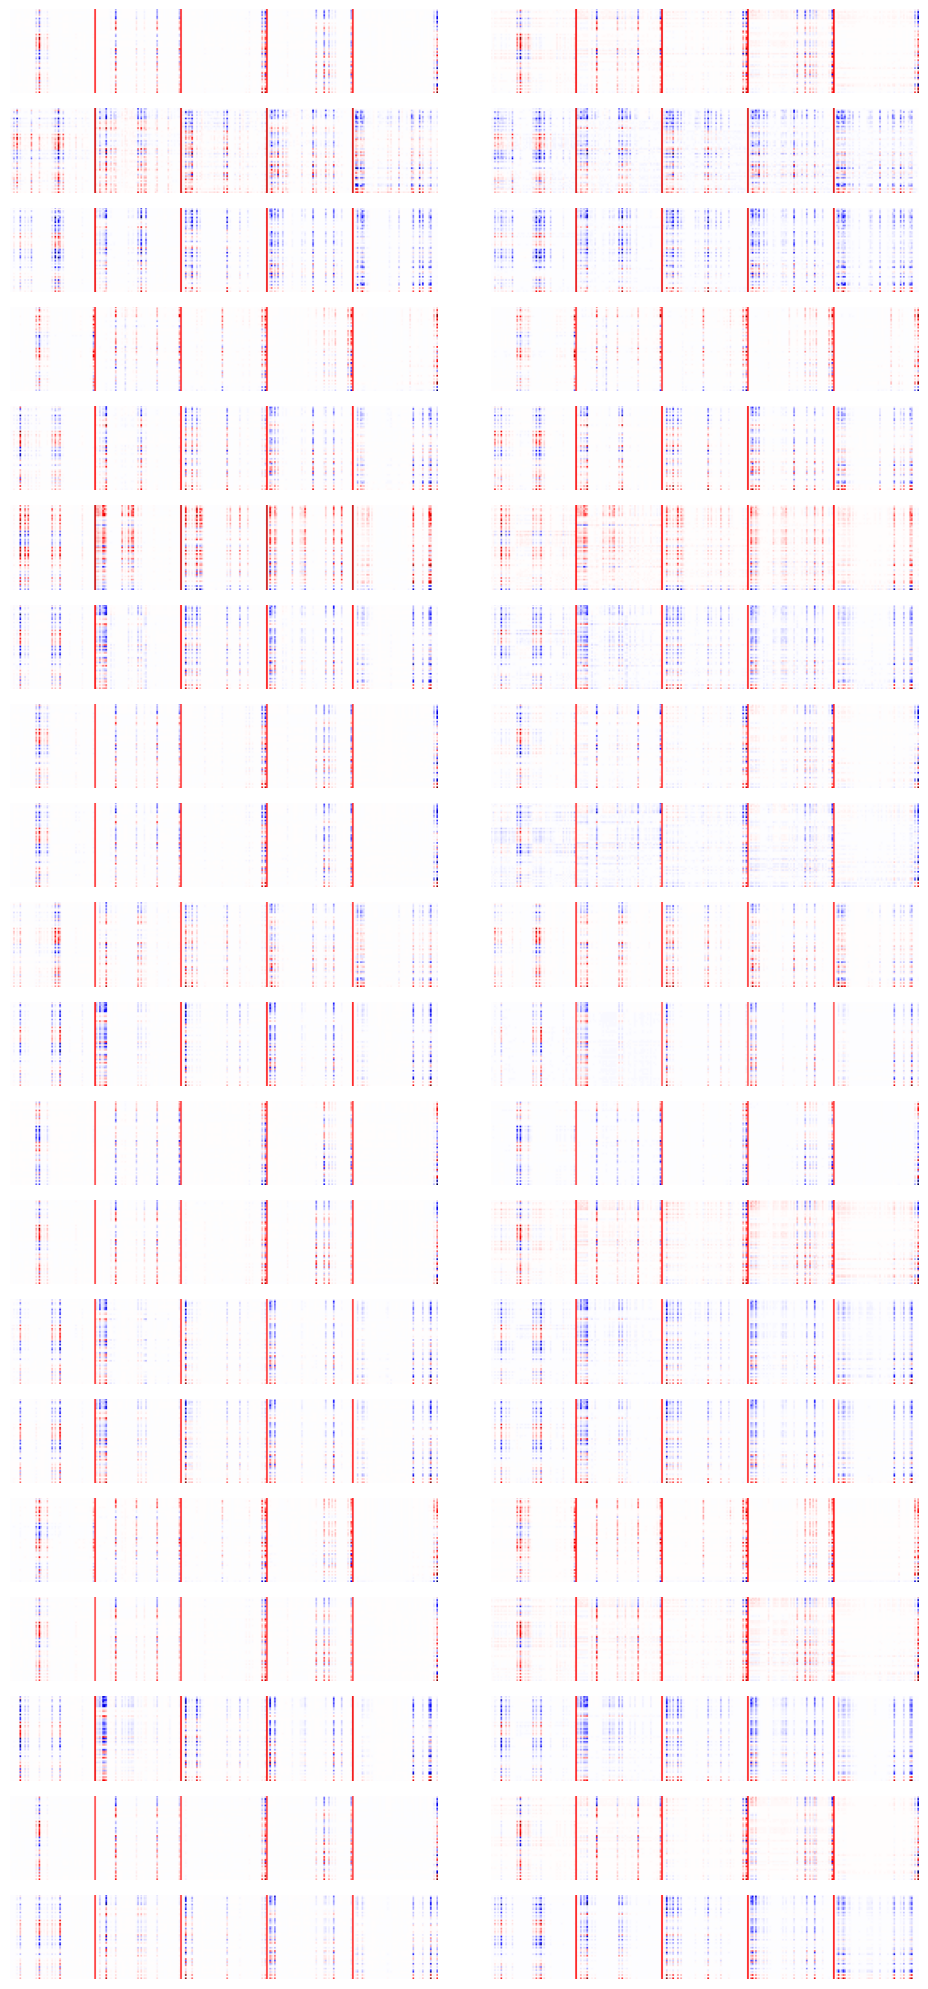

In [15]:
# test_path = f"/data/users2/ppopov1/glass_proj/assets/test_logs/revisitingDBN/eyes_on_clf_3_fbirn"
test_path = f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/eyes_on_clf_3_fbirn"

# for i in range(20):
#     left_image_path = f"{test_path}_{i}/all/matrix_0.png"
#     right_image_path = f"{test_path}_{i}/all/matrix_99.png"

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(20, 2, figsize=(10, 20))

for idx in range(20):
    left_img = mpimg.imread(f"{test_path}_{idx}/all/matrix_0.png")
    right_img = mpimg.imread(f"{test_path}_{idx}/all/matrix_99.png")

    axes[idx, 0].imshow(left_img)
    axes[idx, 0].axis('off')
    # axes[idx, 0].set_title(f"Matrix 0 - {idx}")

    axes[idx, 1].imshow(right_img)
    axes[idx, 1].axis('off')
    # axes[idx, 1].set_title(f"Matrix 99 - {idx}")

plt.tight_layout()
plt.show()

In [18]:
# plot AUCs

import seaborn as sns

import matplotlib.pyplot as plt

def plot_auc_dictionary(results):
    for key, value in results.items():
        plt.plot(value["Trained model"], label='Trained model')
        plt.plot(value["Pretrained base + trained classifier"], label='Pretrained base + trained classifier')
        plt.xlabel('Pretraining weights index')
        plt.ylabel('ROC AUC')
        plt.xticks(range(0, len(value["Trained model"]), 1))
        plt.legend()
        plt.title(key)
        plt.show()

def plot_auc_dictionary_boxplot(results):
    data = []
    for key, value in results.items():
        for subkey in value.keys():
            if subkey != "Best indices":
                for auc in value[subkey]:
                    data.append({"Configuration": key, "Model": subkey, "ROC AUC": auc})

    df = pd.DataFrame(data)
    sns.boxplot(x="Configuration", y="ROC AUC", hue="Model", data=df)
    plt.legend(loc='best')
    plt.show()

# dataloaders, ds_name, hold_data, hold_labels = get_fbirn()
dataloaders, ds_name, hold_data, hold_labels = get_fbirn_sex()

# auc_paths = {
#     "CE 1/1 IP+SP": f"/data/users2/ppopov1/glass_proj/assets/test_logs/revisitingDBN/{ds_name}",
#     "CE 2/1 IP+SP": f"/data/users2/ppopov1/glass_proj/assets/test_logs/revisitingDBN/eyes_on_clf_{ds_name}",
#     "CE 10/1 IP+SP": f"/data/users2/ppopov1/glass_proj/assets/test_logs/revisitingDBN/eyes_on_clf_2_{ds_name}",
#     "CE 50/1 IP+SP": f"/data/users2/ppopov1/glass_proj/assets/test_logs/revisitingDBN/eyes_on_clf_3_{ds_name}",
# }
auc_paths = {
    "CE 1/1 IP+SP": f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/{ds_name}",
    "CE 2/1 IP+SP": f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/eyes_on_clf_{ds_name}",
    "CE 10/1 IP+SP": f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/eyes_on_clf_2_{ds_name}",
    "CE 50/1 IP+SP": f"/data/users2/ppopov1/glass_proj/assets/test_logs/glassDBN/eyes_on_clf_3_{ds_name}",
}
results = {}

for key, test_path in auc_paths.items():
    orig_results = []
    # for i in list(range(20)) + ["orig"]:
    for i in range(20):
        test_results = pd.read_csv(f"{test_path}_{i}/test_results.csv")
        val_results = pd.read_csv(f"{test_path}_{i}/val_results.csv")

        best_index = val_results["valid_average_loss"].idxmin()
        best_test_result = test_results["test_roc_auc"].iloc[best_index]
        orig_results.append(best_test_result)

    new_results = []
    best_indices = []


    # for i in list(range(20)) + ["orig"]:
    for i in range(20):
        with open_dict(model_cfg):
            model_cfg.input_size = 53
            model_cfg.loss.pred_weight = 1.0
            model_cfg.loss.sp_weight = 1.0
            model_cfg.load_pretrained = True


        model = glassDBN(model_cfg).to(device)
        base_path = f"/data/users2/ppopov1/glass_proj/assets/model_weights/DBNglassFIX_ukb_{i}.pt" if i != "orig" else f"/data/users2/ppopov1/glass_proj/assets/model_weights/DBNglassFIX_ukb.pt"
        base_checkpoint = torch.load(base_path)
        base_checkpoint = {k: v for k, v in base_checkpoint.items() if "clf" not in k}

        val_results = pd.read_csv(f"{test_path}_{i}/val_results.csv")
        best_index = val_results["valid_average_loss"].idxmin()
        best_indices.append(best_index) # for later
        clf_path = f"{test_path}_{i}/checkpoints/model_{best_index}.pth"
        clf_checkpoint = torch.load(clf_path)
        clf_checkpoint = {k: v for k, v in clf_checkpoint.items() if "clf" in k}
        
        checkpoint = {**base_checkpoint, **clf_checkpoint}
        model.load_state_dict(checkpoint, strict=True)
        model.eval()

        loss, metrics = run_epoch(model, dataloaders, "test")
        auc = metrics["test_roc_auc"]
        new_results.append(auc)

    results[key] = {
        "Trained model": orig_results,
        "Pretrained base + trained classifier": new_results,
        "Best indices": best_indices
    }




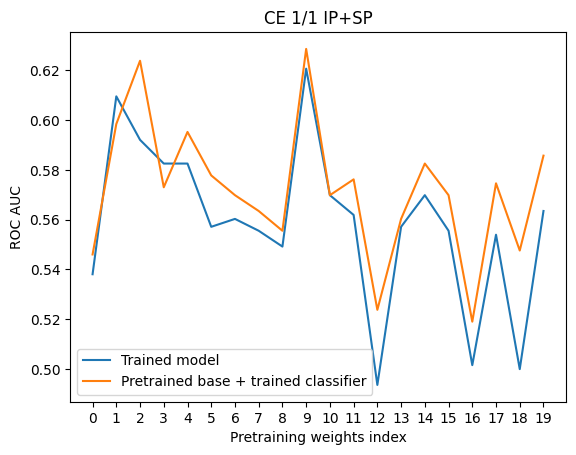

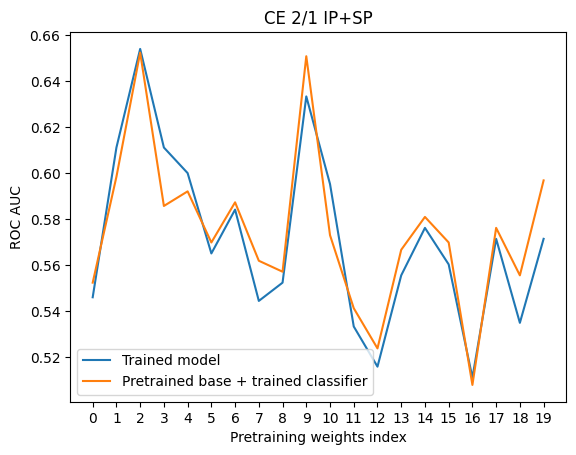

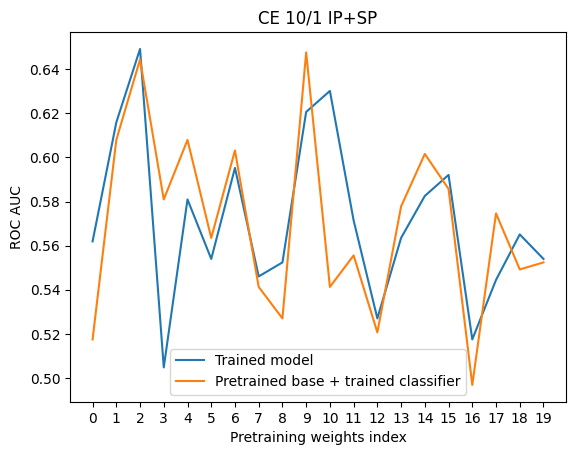

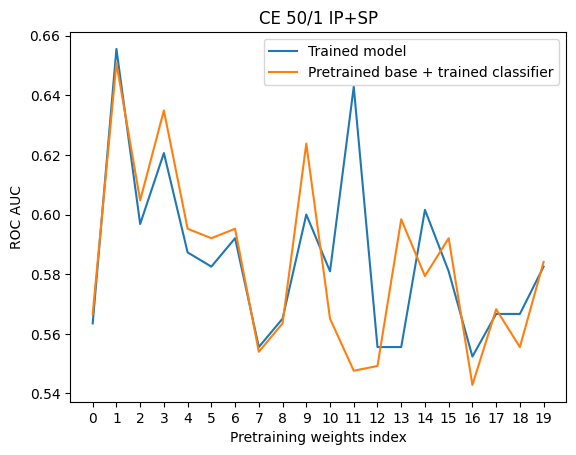

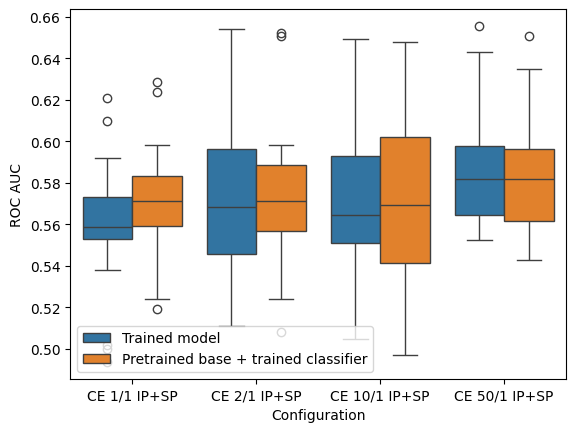

In [19]:
plot_auc_dictionary(results)

plot_auc_dictionary_boxplot(results)

In [144]:
mirror_results = []
for val in new_results:
    corr_val = 1 - val if val < 0.5 else val
    mirror_results.append(corr_val)
new_results = mirror_results

In [100]:

import shutil

for i in range(20):
    first_matrix = f"/data/users2/ppopov1/glass_proj/assets/test_logs/revisitingDBN/fbirn_{i}/all/matrix_0.png"
    last_matrix = f"/data/users2/ppopov1/glass_proj/assets/test_logs/revisitingDBN/fbirn_{i}/all/matrix_99.png"
    first_mean_matrix = f"/data/users2/ppopov1/glass_proj/assets/test_logs/revisitingDBN/fbirn_{i}/mean/matrix_mean_0.png"
    last_mean_matrix = f"/data/users2/ppopov1/glass_proj/assets/test_logs/revisitingDBN/fbirn_{i}/mean/matrix_mean_99.png"

    classification_diff = results[i] - new_results[i]

    save_path = f"/data/users2/ppopov1/glass_proj/assets/test_logs/revisitingDBN/_inspect_matrices/{i}_auc_diff_{classification_diff:.3f}/"

    os.makedirs(save_path, exist_ok=True)
    shutil.copy(first_matrix, os.path.join(save_path, "first_matrix.png"))
    shutil.copy(last_matrix, os.path.join(save_path, "last_matrix.png"))
    shutil.copy(first_mean_matrix, os.path.join(save_path, "first_mean_matrix.png"))
    shutil.copy(last_mean_matrix, os.path.join(save_path, "last_mean_matrix.png"))

    

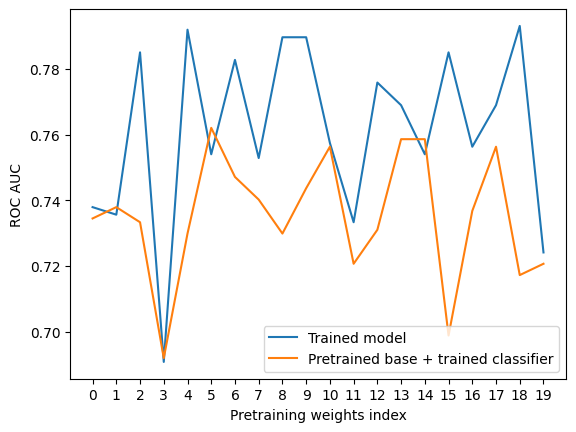

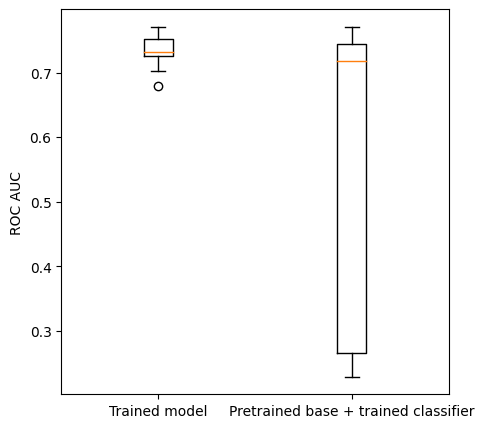

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.boxplot([results, new_results], labels=['Trained model', 'Pretrained base + trained classifier'])
plt.ylabel('ROC AUC')
plt.show()

# testing pretrained model on FBIRN

In [ ]:
# train the pretrained model
from omegaconf import open_dict

dataloaders, ds_name, hold_data, hold_labels = get_fbirn()
# dataloaders, ds_name, hold_data, hold_labels = get_fbirn_sex()

for i in range(6):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
        model_cfg.load_pretrained = True

    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/best_run_{ds_name}_{i}/"

    model = BrainDynaMoH(model_cfg).to(device)
    path = f"/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/run_ukb_{i}/best_model.pth"
    checkpoint = torch.load(
        path, map_location=lambda storage, loc: storage
    )
    dont_load = ["clf"]
    pruned_checkpoint = {k: v for k, v in checkpoint.items() if not any(key in k for key in dont_load)}
    model.load_state_dict(pruned_checkpoint, strict=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

dataloaders, ds_name, hold_data, hold_labels = get_fbirn_sex()

for i in range(6):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
        model_cfg.load_pretrained = True

    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/best_run_{ds_name}_{i}/"

    model = BrainDynaMoH(model_cfg).to(device)
    path = f"/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/run_ukb_{i}/best_model.pth"
    checkpoint = torch.load(
        path, map_location=lambda storage, loc: storage
    )
    dont_load = ["clf"]
    pruned_checkpoint = {k: v for k, v in checkpoint.items() if not any(key in k for key in dont_load)}
    model.load_state_dict(pruned_checkpoint, strict=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

"""
range=3
tile=1x$((range + 1))
h_tile=$((range + 1))x1

montage $(for i in $(seq 0 $range); do echo "pretrained_run_${i}/all/matrix_99.png"; done) -tile $tile -geometry +1+1 trained_pretrained.png
montage $(for i in $(seq 0 $range); do echo "pretrained_run_${i}/mean/matrix_mean_99.png"; done) -tile $h_tile -geometry +1+1 trained_pretrained_means.png

montage $(for i in $(seq 0 $range); do echo "pretrained_run_fbirn_sex_${i}/all/matrix_99.png"; done) -tile $tile -geometry +1+1 trained_pretrained_sex.png
montage $(for i in $(seq 0 $range); do echo "pretrained_run_fbirn_sex_${i}/mean/matrix_mean_99.png"; done) -tile $h_tile -geometry +1+1 trained_pretrained_means_sex.png

"""

# test run

In [ ]:
# test run

dataloaders, ds_name, hold_data, hold_labels = get_fbirn()

from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 53


savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/test/"
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

results_sz = run_experiment(4, model, dataloaders, hold_data, optimizer, save_path=savepath)

"""
to make gif:

file_list=$(for i in {0..3}; do [[ -f "_test_fbirn_sz_${i}.png" ]] && echo "_test_fbirn_sz_${i}.png"; done | sort -V)
convert -delay 20 -loop 0 $file_list _test_fbirn_sz.gif
"""


# looking closer at the training (slow vs fast LR)

In [ ]:
# looking closer at the training (slow vs fast LR)

dataloaders, ds_name, hold_data, hold_labels = get_fbirn()

from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 53

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/fast_learning/"
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
results_fast = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath)

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/slow_learning/"
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
results_slow = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath)

"""
file_list=$(for i in {0..399}; do [[ -f "fast_learning/matrix_${i}.png" ]] && echo "fast_learning/matrix_${i}.png"; done | sort -V)
convert -delay 10 -loop 1 $file_list _fast_learning.gif

file_list=$(for i in {0..399}; do [[ -f "slow_learning/matrix_${i}.png" ]] && echo "slow_learning/matrix_${i}.png"; done | sort -V)
convert -delay 10 -loop 1 $file_list _slow_learning.gif
"""

# testing different loss configs

In [ ]:
# trying different configurations of the loss
from omegaconf import open_dict
import seaborn as sns

dataloaders, ds_name, hold_data, hold_labels = get_fbirn()

for i in range(10):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/all_losses_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_pred_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_pred_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_sp_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_sp_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/only_ce_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    only_ce_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_ce_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True)

# scores = get_scores(basepath = "/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/")
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='savepath', y='test_roc_auc', data=scores)
# plt.title('Test ROC AUC Scores by Configuration')
# plt.xlabel('Configuration')
# plt.ylabel('Test ROC AUC')
# plt.xticks(rotation=45)
# plt.show()

"""
file_list=$(for i in {0..100}; do [[ -f "all_losses/matrix_${i}.png" ]] && echo "all_losses/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 0 $file_list _all_losses.gif;

file_list=$(for i in {0..100}; do [[ -f "no_pred/matrix_${i}.png" ]] && echo "no_pred/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 0 $file_list _no_pred.gif;

file_list=$(for i in {0..100}; do [[ -f "no_sp/matrix_${i}.png" ]] && echo "no_sp/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 0 $file_list _no_sp.gif;

file_list=$(for i in {0..100}; do [[ -f "only_ce/matrix_${i}.png" ]] && echo "only_ce/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 0 $file_list _only_ce.gif;

file_list=$(for i in {0..100}; do [[ -f "no_ce/matrix_${i}.png" ]] && echo "no_ce/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 0 $file_list _no_ce.gif;
"""

In [ ]:
# trying different configurations of the loss with the hidden state classifier
from omegaconf import open_dict
import seaborn as sns

for i in range(10):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/HS_classifier/all_losses_{i}/"
    model = BrainDynaMoH(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/HS_classifier/no_pred_{i}/"
    model = BrainDynaMoH(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_pred_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    # with open_dict(model_cfg):
    #     model_cfg.input_size = 53
    #     model_cfg.loss.pred_weight = 1.0
    #     model_cfg.loss.sp_weight = None
    # savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/HS_classifier/no_sp_{i}/"
    # model = BrainDynaMoH(model_cfg).to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    # no_sp_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    # with open_dict(model_cfg):
    #     model_cfg.input_size = 53
    #     model_cfg.loss.pred_weight = None
    #     model_cfg.loss.sp_weight = None
    # savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/HS_classifier/only_ce_{i}/"
    # model = BrainDynaMoH(model_cfg).to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    # only_ce_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/HS_classifier/no_ce_{i}/"
    model = BrainDynaMoH(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True)

# scores = get_scores(basepath = "/data/users2/ppopov1/glass_proj/assets/test_logs/HS_classifier/")
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='savepath', y='test_roc_auc', data=scores)
# plt.title('Test ROC AUC Scores by Configuration')
# plt.xlabel('Configuration')
# plt.ylabel('Test ROC AUC')
# plt.xticks(rotation=45)
# plt.show()

"""
range=9
tile=1x$((range + 1))

montage $(for i in $(seq 0 $range); do echo "all_losses_${i}/all/matrix_99.png"; done) -tile $tile -geometry +1+1 all_losses_combined.png
montage $(for i in $(seq 0 $range); do echo "no_ce_${i}/all/matrix_99.png"; done) -tile $tile -geometry +1+1 no_ce_combined.png
montage $(for i in $(seq 0 $range); do echo "no_pred_${i}/all/matrix_49.png"; done) -tile $tile -geometry +1+1 no_pred_combined.png
montage all_losses_combined.png no_ce_combined.png no_pred_combined.png -tile 3x1 -geometry +1+1 __all_losses.png
"""

In [ ]:
# trying different configurations of the loss with a wider predictor model
from omegaconf import open_dict

for i in range(6, 10):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/WidePredictor/all_losses_{i}/"
    model = WidePredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/WidePredictor/no_pred_{i}/"
    model = WidePredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_pred_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/WidePredictor/no_sp_{i}/"
    model = WidePredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_sp_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/WidePredictor/only_ce_{i}/"
    model = WidePredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    only_ce_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/WidePredictor/no_ce_{i}/"
    model = WidePredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True)


"""
montage $(for i in {0..2}; do echo "all_losses_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "all_losses" all_losses_combined.png;
montage $(for i in {0..2}; do echo "no_pred_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_pred" no_pred_combined.png;
montage $(for i in {0..2}; do echo "no_sp_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_sp" no_sp_combined.png;
montage $(for i in {0..2}; do echo "only_ce_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "only_ce" only_ce_combined.png;
montage $(for i in {0..2}; do echo "no_ce_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_ce" no_ce_combined.png;
montage all_losses_combined.png no_pred_combined.png no_ce_combined.png no_sp_combined.png only_ce_combined.png -tile 5x1 -geometry +2+2 __all_losses.png;
"""

In [ ]:
# trying different configurations of the loss with a deeper predictor model
from omegaconf import open_dict

for i in range(10):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/DeepPredictor/all_losses_{i}/"
    model = DeepPredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/DeepPredictor/no_pred_{i}/"
    model = DeepPredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_pred_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/DeepPredictor/no_sp_{i}/"
    model = DeepPredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_sp_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/DeepPredictor/only_ce_{i}/"
    model = DeepPredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    only_ce_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/DeepPredictor/no_ce_{i}/"
    model = DeepPredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True)

"""
montage $(for i in {0..2}; do echo "all_losses_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "all_losses" all_losses_combined.png;
montage $(for i in {0..2}; do echo "no_pred_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_pred" no_pred_combined.png;
montage $(for i in {0..2}; do echo "no_sp_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_sp" no_sp_combined.png;
montage $(for i in {0..2}; do echo "only_ce_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "only_ce" only_ce_combined.png;
montage $(for i in {0..2}; do echo "no_ce_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_ce" no_ce_combined.png;
montage all_losses_combined.png no_pred_combined.png no_ce_combined.png no_sp_combined.png only_ce_combined.png -tile 5x1 -geometry +2+2 __all_losses.png;
"""

In [ ]:
# trying different configurations of the loss with an even deeper predictor model
from omegaconf import open_dict

for i in range(10):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
        model_cfg.loss.prediction_depth = 3
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/DeeperPredictor/all_losses_{i}/"
    model = DeepPredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = 1.0
        model_cfg.loss.prediction_depth = 3
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/DeeperPredictor/no_pred_{i}/"
    model = DeepPredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_pred_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = None
        model_cfg.loss.prediction_depth = 3
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/DeeperPredictor/no_sp_{i}/"
    model = DeepPredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_sp_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = None
        model_cfg.loss.prediction_depth = 3
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/DeeperPredictor/only_ce_{i}/"
    model = DeepPredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    only_ce_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
        model_cfg.loss.prediction_depth = 3
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/DeeperPredictor/no_ce_{i}/"
    model = DeepPredictor(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True)

"""
montage $(for i in {0..9}; do echo "all_losses_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "all_losses" all_losses_combined.png;
montage $(for i in {0..9}; do echo "no_pred_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_pred" no_pred_combined.png;
montage $(for i in {0..9}; do echo "no_sp_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_sp" no_sp_combined.png;
montage $(for i in {0..9}; do echo "only_ce_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "only_ce" only_ce_combined.png;
montage $(for i in {0..9}; do echo "no_ce_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_ce" no_ce_combined.png;
montage all_losses_combined.png no_pred_combined.png no_ce_combined.png no_sp_combined.png only_ce_combined.png -tile 5x1 -geometry +2+2 __all_losses_DeeperPredictor.png;
"""

In [ ]:
# bash script for making gifs of matrices over training epochs
for i in {0..9}; do
    file_list=$(for j in {0..399}; do [[ -f "all_losses_${i}/matrix_${j}.png" ]] && echo "all_losses_${i}/matrix_${j}.png"; done | sort -V);
    convert -delay 10 -loop 1 $file_list "_all_losses_${i}.gif";

    file_list=$(for j in {0..399}; do [[ -f "no_pred_${i}/matrix_${j}.png" ]] && echo "no_pred_${i}/matrix_${j}.png"; done | sort -V);
    convert -delay 10 -loop 1 $file_list "_no_pred_${i}.gif";

    file_list=$(for j in {0..399}; do [[ -f "no_sp_${i}/matrix_${j}.png" ]] && echo "no_sp_${i}/matrix_${j}.png"; done | sort -V);
    convert -delay 10 -loop 1 $file_list "_no_sp_${i}.gif";

    file_list=$(for j in {0..399}; do [[ -f "only_ce_${i}/matrix_${j}.png" ]] && echo "only_ce_${i}/matrix_${j}.png"; done | sort -V);
    convert -delay 10 -loop 1 $file_list "_only_ce_${i}.gif";

    file_list=$(for j in {0..399}; do [[ -f "no_ce_${i}/matrix_${j}.png" ]] && echo "no_ce_${i}/matrix_${j}.png"; done | sort -V);
    convert -delay 10 -loop 1 $file_list "_no_ce_${i}.gif";
done

montage $(for i in {0..9}; do echo "all_losses_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "all_losses" all_losses_combined.png;
montage $(for i in {0..9}; do echo "no_pred_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_pred" no_pred_combined.png;
montage $(for i in {0..9}; do echo "no_sp_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_sp" no_sp_combined.png;
montage $(for i in {0..9}; do echo "only_ce_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "only_ce" only_ce_combined.png;
montage $(for i in {0..9}; do echo "no_ce_${i}/matrix_99.png"; done) -tile 1x10 -geometry +2+2 -title "no_ce" no_ce_combined.png;
montage all_losses_combined.png no_pred_combined.png no_ce_combined.png no_sp_combined.png only_ce_combined.png -tile 5x1 -geometry +2+2 __all_losses.png;

In [ ]:
# training curves plotting
import matplotlib.pyplot as plt

# Extract the dataframes from results_slow
# train_results, val_results, test_results = no_sp_result
# _, all_results, _ = all_losses_result
# _, no_pred_results, _ = no_pred_result
# _, no_sp_results, _ = no_sp_result
# _, ce_results, _ = only_ce_result

basic_results = pd.read_csv("/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_ce_0/val_results.csv")
wide_results = pd.read_csv("/data/users2/ppopov1/glass_proj/assets/test_logs/WidePredictor/no_ce_2/val_results.csv")

# Function to plot loss values from a dataframe
def plot_loss_values(df, title):
    loss_columns = [col for col in df.columns if "loss" in col]
    df[loss_columns].plot(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()
    # plt.savefig(f"{title}.png")

# Plot the loss values for each dataframe
plot_loss_values(basic_results, "Default Losses")
plot_loss_values(wide_results, "Wide predctor Losses")


In [ ]:
# FBIRN Sex: trying different configurations of the loss
from omegaconf import open_dict

dataloaders, ds_name, hold_data, hold_labels = get_fbirn_sex()

for i in range(10):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite_sex/all_losses_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite_sex/no_pred_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_pred_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite_sex/no_sp_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_sp_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite_sex/only_ce_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    only_ce_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite_sex/no_ce_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True)

"""
file_list=$(for i in {0..100}; do [[ -f "all_losses/matrix_${i}.png" ]] && echo "all_losses/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 0 $file_list _all_losses.gif;

file_list=$(for i in {0..100}; do [[ -f "no_pred/matrix_${i}.png" ]] && echo "no_pred/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 0 $file_list _no_pred.gif;

file_list=$(for i in {0..100}; do [[ -f "no_sp/matrix_${i}.png" ]] && echo "no_sp/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 0 $file_list _no_sp.gif;

file_list=$(for i in {0..100}; do [[ -f "only_ce/matrix_${i}.png" ]] && echo "only_ce/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 0 $file_list _only_ce.gif;

file_list=$(for i in {0..100}; do [[ -f "no_ce/matrix_${i}.png" ]] && echo "no_ce/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 0 $file_list _no_ce.gif;
"""

In [ ]:
# plot loss curves (reusable stuff if you have a path to csv results)
import matplotlib.pyplot as plt

# Extract the dataframes from results_slow
# train_results, val_results, test_results = no_sp_result
# _, all_results, _ = all_losses_result
# _, no_pred_results, _ = no_pred_result
# _, no_sp_results, _ = no_sp_result
# _, ce_results, _ = only_ce_result

basic_results = pd.read_csv("/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/all_losses_1/val_results.csv")
basic_results_sex = pd.read_csv("/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite_sex/all_losses_1/val_results.csv")

# Function to plot loss values from a dataframe
def plot_loss_values(df, title):
    loss_columns = [col for col in df.columns if "loss" in col]
    df[loss_columns].plot(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()
    # plt.savefig(f"{title}.png")

# Plot the loss values for each dataframe
plot_loss_values(basic_results, "SZ Losses")
plot_loss_values(basic_results_sex, "Sex Losses")

# run synthetic data (causal networks)

In [ ]:
# trying different configurations of the loss with the model
from omegaconf import open_dict

dataloaders, ds_name, hold_data, hold_labels = get_2nets()

for i in range(10):
    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_2_nets/all_losses_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(50, model, dataloaders, hold_data, optimizer, save_path=savepath, plot_all=True)

    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_2_nets/no_pred_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_pred_result = run_experiment(50, model, dataloaders, hold_data, optimizer, save_path=savepath, plot_all=True)

    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_2_nets/no_sp_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_sp_result = run_experiment(50, model, dataloaders, hold_data, optimizer, save_path=savepath, plot_all=True)

    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_2_nets/only_ce_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    only_ce_result = run_experiment(50, model, dataloaders, hold_data, optimizer, save_path=savepath, plot_all=True)

    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_2_nets/no_ce_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(50, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True, plot_all=True)

"""
montage $(for i in {0..9}; do echo "all_losses_${i}/matrix_49.png"; done) -tile 1x10 -geometry +2+2 -title "all_losses" all_losses_combined.png;
montage $(for i in {0..9}; do echo "no_pred_${i}/matrix_49.png"; done) -tile 1x10 -geometry +2+2 -title "no_pred" no_pred_combined.png;
montage $(for i in {0..9}; do echo "no_sp_${i}/matrix_49.png"; done) -tile 1x10 -geometry +2+2 -title "no_sp" no_sp_combined.png;
montage $(for i in {0..9}; do echo "only_ce_${i}/matrix_49.png"; done) -tile 1x10 -geometry +2+2 -title "only_ce" only_ce_combined.png;
montage $(for i in {0..9}; do echo "no_ce_${i}/matrix_49.png"; done) -tile 1x10 -geometry +2+2 -title "no_ce" no_ce_combined.png;
montage all_losses_combined.png no_pred_combined.png no_ce_combined.png no_sp_combined.png only_ce_combined.png -tile 5x1 -geometry +2+2 __all_losses.png;
"""

In [244]:
# just a plotting script, keep rolled up

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

def plot_data(data, true_networks, save_path_prefix, n_runs):
    # Draw vertical separator lines
    
    for name, (d, preds) in data.items():
        # for name, d in data.items():
        vmax = np.max(np.abs(d))
        vmin = -vmax

        fig = plt.figure(figsize=(22, 11))
        gs = gridspec.GridSpec(12, 23, width_ratios=[1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1])

        # plot the true networks on top
        for j in range(20):
            col = j + j // 5
            ax = fig.add_subplot(gs[0, col])
            matrix = true_networks[j // 5]
            im = ax.imshow(matrix, cmap='seismic', vmin=-2, vmax=2)
            ax.axis('off')
            ax = fig.add_subplot(gs[1, col])
            ax.axis('off')

        for i in range(n_runs):
            for j in range(20):
                col = j + j // 5
                ax = fig.add_subplot(gs[i+2, col])
                matrix = d[i, j]
                im = ax.imshow(matrix, cmap='seismic', vmin=vmin, vmax=vmax)
                ax.axis('off')
                ax.set_title(f"pred: {preds[i, j]}", fontsize=8)
        
    

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.tight_layout()
        plt.savefig(f"{save_path_prefix}_{name}.png", dpi=300)
        plt.close()

In [ ]:
# testing HS classifier
from omegaconf import open_dict

dataloaders, ds_name, hold_data, hold_labels = get_4nets()

for i in range(10):

    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.output_size = 4
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/4nets_all_losses_{i}/"
    model = BrainDynaMoH(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.output_size = 4
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/4nets_no_ce_{i}/"
    model = BrainDynaMoH(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True)

In [ ]:
# weighted aggregation

dataloaders, ds_name, hold_data, hold_labels = get_4nets()

from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 5
    model_cfg.output_size = 4

n_runs = 10
all_matrices = []
mean_matrices = []
all_preds = []
for i in range(n_runs):
    model = BrainDynaMoH(model_cfg).to(device)
    path = f"/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/4nets_all_losses_{i}/"
    model.load_state_dict(torch.load(path+"last_model.pth"))
    model.eval()

    logits, outputs = model(hold_data)
    matrices = outputs["FNCs"][:, 5:].cpu().detach().numpy()
    time_logits = outputs["time_logits"]

    all_matrices.append(matrices)

    pred_class = torch.argmax(logits, dim=1)

    all_preds.append(pred_class.cpu().detach().numpy())

    # # WEIGHTED average
    # predicted = torch.nn.functional.softmax(time_logits, dim=2).cpu().detach().numpy()

    # new_predicted = np.zeros((predicted.shape[0], predicted.shape[1]))
    # for j in range(4):

    #     ## for weighted averaging
    #     # new_predicted[j*5:(j+1)*5, :] = predicted[j*5:(j+1)*5, :, j]
        
    #     ## for weighted averaging with zeros where the prediction is wrong
    #     max_values = predicted[j*5:(j+1)*5, :, j].max(axis=1)
    #     for k in range(predicted.shape[1]):
    #         condition = predicted[j*5:(j+1)*5, k, j] == max_values
    #         new_predicted[j*5:(j+1)*5, k] = np.where(condition, predicted[j*5:(j+1)*5, k, j], 0)

    # result = matrices * new_predicted[:, :, None, None]
    # summed = np.sum(result, axis=1)
    # div = np.sum(new_predicted, axis=1)
    # averaged = summed/div[:, None, None]

    # JUST average:
    averaged = np.mean(matrices, 1)

    # append
    mean_matrices.append(averaged)

all_matrices = np.array(all_matrices)
mean_matrices = np.array(mean_matrices)
all_preds = np.array(all_preds)

data = {
    # "weighted_0_metric_noDiag": (mean_matrices, all_preds),
    # "weighted_metric_noDiag": (mean_matrices, all_preds),
    # "average_metric_noDiag": (mean_matrices, all_preds),
}

plot_data_and_metric(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/1_", n_runs)

In [68]:
# a plotting script with metric 

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

def plot_data_and_metric(data, true_networks, save_path_prefix, n_runs):
    # Draw vertical separator lines
    
    for name, (d, preds) in data.items():
        # for name, d in data.items():
        vmax = np.max(np.abs(d))
        vmin = -vmax

        fig = plt.figure(figsize=(22, 11))
        gs = gridspec.GridSpec(12, 23, width_ratios=[1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1])

        # plot the true networks on top
        for j in range(20):
            col = j + j // 5
            ax = fig.add_subplot(gs[0, col])
            matrix = true_networks[j // 5]
            im = ax.imshow(matrix, cmap='seismic', vmin=-2, vmax=2)
            ax.axis('off')
            ax = fig.add_subplot(gs[1, col])
            ax.axis('off')

        for i in range(n_runs):
            mean_metric = 0
            for j in range(20):

                ground_truth = true_networks[j // 5]

                good_stuff = (ground_truth != 0).astype(int)
                unrelated_stuff = (ground_truth == 0).astype(int)

                good_overlap = np.abs(good_stuff * d[i, j])
                np.fill_diagonal(good_overlap, 0) #####
                bad_overlap = np.abs(unrelated_stuff * d[i, j])

                good_metric = np.sum(good_overlap) / np.sum(good_stuff)
                bad_metric = np.sum(bad_overlap) / np.sum(unrelated_stuff)

                metric = good_metric/bad_metric
                mean_metric += metric

                col = j + j // 5
                ax = fig.add_subplot(gs[i+2, col])
                matrix = d[i, j]
                im = ax.imshow(matrix, cmap='seismic', vmin=vmin, vmax=vmax)
                ax.axis('off')
                
                ax.set_title(f"Metric: {metric:0.2f}", fontsize=8)

            mean_metric /= 20
            ax = fig.add_subplot(gs[i+2, 5])
            ax.axis('off')
            ax.set_title(f"Mean: \n {mean_metric:0.2f}", fontsize=8)
        
    

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.tight_layout()
        plt.savefig(f"{save_path_prefix}_{name}.png", dpi=300)
        plt.close()

# plot_data_and_metric(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/pretrainingHS/_", n_runs)

In [ ]:
# trying different configurations of the loss with the model
from omegaconf import open_dict

dataloaders, ds_name, hold_data, hold_labels = get_4nets()

for i in range(10):
    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.output_size = 4
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/all_losses_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.output_size = 4
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/no_pred_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_pred_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.output_size = 4
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/no_sp_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_sp_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.output_size = 4
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/only_ce_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    only_ce_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 5
        model_cfg.output_size = 4
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/no_ce_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True)


"""
montage $(for i in {0..8}; do echo "all_losses_${i}/all/matrix_99.png"; done) -tile 1x10 -geometry +1+1 all_losses_combined.png;
montage $(for i in {0..8}; do echo "no_pred_${i}/all/matrix_49.png"; done) -tile 1x10 -geometry +1+1 no_pred_combined.png;
montage $(for i in {0..8}; do echo "no_sp_${i}/all/matrix_99.png"; done) -tile 1x10 -geometry +1+1 no_sp_combined.png;
montage $(for i in {0..8}; do echo "only_ce_${i}/all/matrix_99.png"; done) -tile 1x10 -geometry +1+1 only_ce_combined.png;
montage $(for i in {0..8}; do echo "no_ce_${i}/all/matrix_99.png"; done) -tile 1x10 -geometry +1+1 no_ce_combined.png;
montage all_losses_combined.png no_pred_combined.png no_ce_combined.png no_sp_combined.png only_ce_combined.png -tile 5x1 -geometry +2+2 __all_losses.png;
"""

"""
montage $(for i in {0..8}; do echo "all_losses_${i}/mean/matrix_mean_99.png"; done) -tile 9x1 -geometry +1+1 mean_all_losses_combined.png;
montage $(for i in {0..8}; do echo "no_pred_${i}/mean/matrix_mean_49.png"; done) -tile 9x1 -geometry +1+1 mean_no_pred_combined.png;
montage $(for i in {0..8}; do echo "no_sp_${i}/mean/matrix_mean_99.png"; done) -tile 9x1 -geometry +1+1 mean_no_sp_combined.png;
montage $(for i in {0..8}; do echo "only_ce_${i}/mean/matrix_mean_99.png"; done) -tile 9x1 -geometry +1+1 mean_only_ce_combined.png;
montage $(for i in {0..8}; do echo "no_ce_${i}/mean/matrix_mean_99.png"; done) -tile 9x1 -geometry +1+1 mean_no_ce_combined.png;
montage all_losses_combined.png no_pred_combined.png no_ce_combined.png no_sp_combined.png only_ce_combined.png -tile 5x1 -geometry +2+2 __all_losses.png;
"""

In [49]:
# plotting script for the previous cell
all_losses, no_ce, no_pred, no_sp, only_ce = [], [], [], [], []
for i in range(10):
    all_losses.append(np.load(f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/all_losses_{i}/holdout_matrices.npy"))
    no_ce.append(np.load(f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/no_pred_{i}/holdout_matrices.npy"))
    no_pred.append(np.load(f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/no_sp_{i}/holdout_matrices.npy"))
    no_sp.append(np.load(f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/only_ce_{i}/holdout_matrices.npy"))
    only_ce.append(np.load(f"/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/no_ce_{i}/holdout_matrices.npy"))

all_losses = np.array(all_losses).mean(axis=2)
no_ce = np.array(no_ce).mean(axis=2)
no_pred = np.array(no_pred).mean(axis=2)
no_sp = np.array(no_sp).mean(axis=2)
only_ce = np.array(only_ce).mean(axis=2)


In [37]:
# more plotting

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

data = {
    # "all_losses": all_losses,
    "no_ce": no_ce,
    # "no_pred": no_pred,
    # "no_sp": no_sp,
    # "only_ce": only_ce
}

import matplotlib.pyplot as plt

# Define the function to plot the data
def plot_data(data, true_networks, save_path_prefix):
    # Draw vertical separator lines
    
    for name, d in data.items():
        vmax = np.max(d)
        vmin = -vmax

        fig = plt.figure(figsize=(22, 11))
        gs = gridspec.GridSpec(12, 23, width_ratios=[1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1])

        # plot the true networks on top
        for j in range(20):
            col = j + j // 5
            ax = fig.add_subplot(gs[0, col])
            matrix = true_networks[j // 5]
            im = ax.imshow(matrix, cmap='seismic', vmin=-2, vmax=2)
            ax.axis('off')
            ax = fig.add_subplot(gs[1, col])
            ax.axis('off')

        for i in range(10):
            for j in range(20):
                col = j + j // 5
                ax = fig.add_subplot(gs[i+2, col])
                matrix = d[i, j]
                im = ax.imshow(matrix, cmap='seismic', vmin=vmin, vmax=vmax)
                ax.axis('off')
        
    

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.tight_layout()
        plt.savefig(f"{save_path_prefix}_{name}.png", dpi=300)
        plt.close()

def plot_data_diff(data, true_networks, save_path_prefix, group):
    # Draw vertical separator lines
    
    for name, d in data.items():
        vmax = np.max(d)
        vmin = -vmax

        fig = plt.figure(figsize=(22, 11))
        gs = gridspec.GridSpec(12, 23, width_ratios=[1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1])

        mean_matrix = true_networks[group]
        # plot the true networks on top
        for j in range(20):
            col = j + j // 5
            ax = fig.add_subplot(gs[0, col])
            matrix = true_networks[j // 5] - mean_matrix
            im = ax.imshow(matrix, cmap='seismic', vmin=-2, vmax=2)
            ax.axis('off')
            ax = fig.add_subplot(gs[1, col])
            ax.axis('off')

        for i in range(10):
            mean_matrix = d[i, 5*group:5*(group+1)].mean(axis=0)
            for j in range(20):
                col = j + j // 5
                ax = fig.add_subplot(gs[i+2, col])
                matrix = d[i, j] - mean_matrix
                im = ax.imshow(matrix, cmap='seismic', vmin=vmin, vmax=vmax)
                ax.axis('off')
        
    

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.tight_layout()
        plt.savefig(f"{save_path_prefix}_{name}.png", dpi=300)
        plt.close()

# Call the function to plot the data
plot_data(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/output")
plot_data_diff(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/diff_0", 0)
plot_data_diff(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/diff_1", 1)
plot_data_diff(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/diff_2", 2)
plot_data_diff(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/rewrite_4_nets/diff_3", 3)



# training on 4 nets separately

In [30]:
# load 4 networks data separately

fbirn_data, fbirn_labels = load_4nets_main()
fbirn_hold_data, fbirn_hold_labels = load_4nets_holdout()
dataloaders, hold_data, hold_labels = [], [], []

for i in range(4):
    dataloader, hold_dat, hold_label = prepare_dataloaders(
        fbirn_data[fbirn_labels == i],
        np.zeros_like(fbirn_labels[fbirn_labels == i]),
        k=0,
        hold_data=fbirn_hold_data[fbirn_hold_labels == i],
        hold_labels=fbirn_hold_labels[fbirn_hold_labels == i]
    )
    
    dataloaders.append(dataloader)
    hold_data.append(hold_dat)
    hold_labels.append(hold_label)

network1 = np.array([
    [-1, 1, 0, 0, 0],
    [1, -1, 0, 0, 0],
    [0, 1, -1, 0, 0],
    [0, 0, 1, -1, 0],
    [1, 0, 0, 1, -1]
])
network2 = np.array([
    [-1, 1, 0, 0, 0],
    [1, -1, 1, 0, 0],
    [0, 1, -1, 0, 0],
    [0, 0, 1, -1, 0],
    [1, 0, 0, 1, -1]
])
network3 = np.array([
    [-1, 1, 0, 0, 0],
    [1, -1, 0, 0, 0],
    [0, 1, -1, 1, 0],
    [0, 0, 1, -1, 0],
    [1, 0, 0, 1, -1]
])
network5 = np.array([
    [-1, 0, 0, 0, 0],
    [0, -1, 0, 0, 0],
    [1, 0, -1, 1, 0],
    [0, 1, 1, -1, 0],
    [0, 0, 1, 0, -1]
])
true_networks = np.array([network1, network2, network3, network5])


In [ ]:
# train on separate networks for signal prediction
from omegaconf import open_dict

for i in range(10):
    for j in range(4):
        with open_dict(model_cfg):
            model_cfg.input_size = 5
            model_cfg.output_size = 1
            model_cfg.loss.pred_weight = 1.0
            model_cfg.loss.sp_weight = 1.0
        savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/4_nets_1by1/no_ce_{i}_class_{j}/"
        model = BrainDynaMo(model_cfg).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
        all_losses_result = run_experiment(200, model, dataloaders[j], hold_data[j], optimizer, save_path=savepath, pretraining=True)


In [66]:
no_ce = []
for i in range(10):
    no_ce_i = [np.load(f"/data/users2/ppopov1/glass_proj/assets/test_logs/4_nets_1by1/no_ce_{i}_class_{j}/holdout_matrices.npy") for j in range(4)]
    no_ce_i = np.vstack(no_ce_i)
    no_ce.append(no_ce_i)

no_ce = np.array(no_ce).mean(axis=2)

In [39]:
# more plotting

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

data = {
    "no_ce": no_ce,
}

import matplotlib.pyplot as plt

# Define the function to plot the data
def plot_data(data, true_networks, save_path_prefix):
    # Draw vertical separator lines
    
    for name, d in data.items():
        vmax = np.max(d)
        vmin = -vmax

        fig = plt.figure(figsize=(22, 11))
        gs = gridspec.GridSpec(12, 23, width_ratios=[1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1])

        # plot the true networks on top
        for j in range(20):
            col = j + j // 5
            ax = fig.add_subplot(gs[0, col])
            matrix = true_networks[j // 5]
            im = ax.imshow(matrix, cmap='seismic', vmin=-2, vmax=2)
            ax.axis('off')
            ax = fig.add_subplot(gs[1, col])
            ax.axis('off')

        for i in range(10):
            for j in range(20):
                col = j + j // 5
                ax = fig.add_subplot(gs[i+2, col])
                matrix = d[i, j]
                im = ax.imshow(matrix, cmap='seismic', vmin=vmin, vmax=vmax)
                ax.axis('off')
        
    

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.tight_layout()
        plt.savefig(f"{save_path_prefix}_{name}.png", dpi=300)
        plt.close()

# Call the function to plot the data
plot_data(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/4_nets_1by1/output")

plot_data_diff(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/4_nets_1by1/diff_0_c", 0)
plot_data_diff(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/4_nets_1by1/diff_1_c", 1)
plot_data_diff(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/4_nets_1by1/diff_2_c", 2)
plot_data_diff(data, true_networks, "/data/users2/ppopov1/glass_proj/assets/test_logs/4_nets_1by1/diff_3_c", 3)

# run FBIRN Schaefer

In [44]:
fbirn_data, fbirn_labels = load_fbirn_sch()
fbirn_hold_data, fbirn_hold_labels = fbirn_data[300:], fbirn_labels[300:]
fbirn_data, fbirn_labels = fbirn_data[:300], fbirn_labels[:300]
dataloaders, hold_data, hold_labels = prepare_dataloaders(
    fbirn_data,
    fbirn_labels,
    k=0,
    hold_data=fbirn_hold_data,
    hold_labels=fbirn_hold_labels,
    batch_size=16
)

In [ ]:
from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 200
    
# model = glassDBN(model_cfg).to(device)
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

results_schaefer = run_experiment(50, model, dataloaders, hold_data, optimizer, save_path=f"{Logs_Root}fbirn_sch_1")

# file_list=$(for i in {0..49}; do [[ -f "fbirn_sch_${i}.png" ]] && echo "fbirn_sch_${i}.png"; done | sort -V)
# convert -delay 20 -loop 0 $file_list _fbirn_sch_0.gif

# file_list=$(for i in {0..49}; do [[ -f "fbirn_sch_1_${i}.png" ]] && echo "fbirn_sch_1_${i}.png"; done | sort -V)
# convert -delay 20 -loop 0 $file_list _fbirn_sch_1.gif

# analyze framework experiment result

In [7]:
import pandas as pd

models = ["BrainDynaMo", "DBNglassFIX", "mlp"]
datasets = ["fbirn_main", "fbirn_main_sex"]
results = {}
for model in models:
    results[model] = {}
    for dataset in datasets:
        path = f"/data/users2/ppopov1/glass_proj/assets/logs/_7_holdout-exp-{model}-{dataset}/runs.csv"
        results[model][dataset] = pd.read_csv(path)

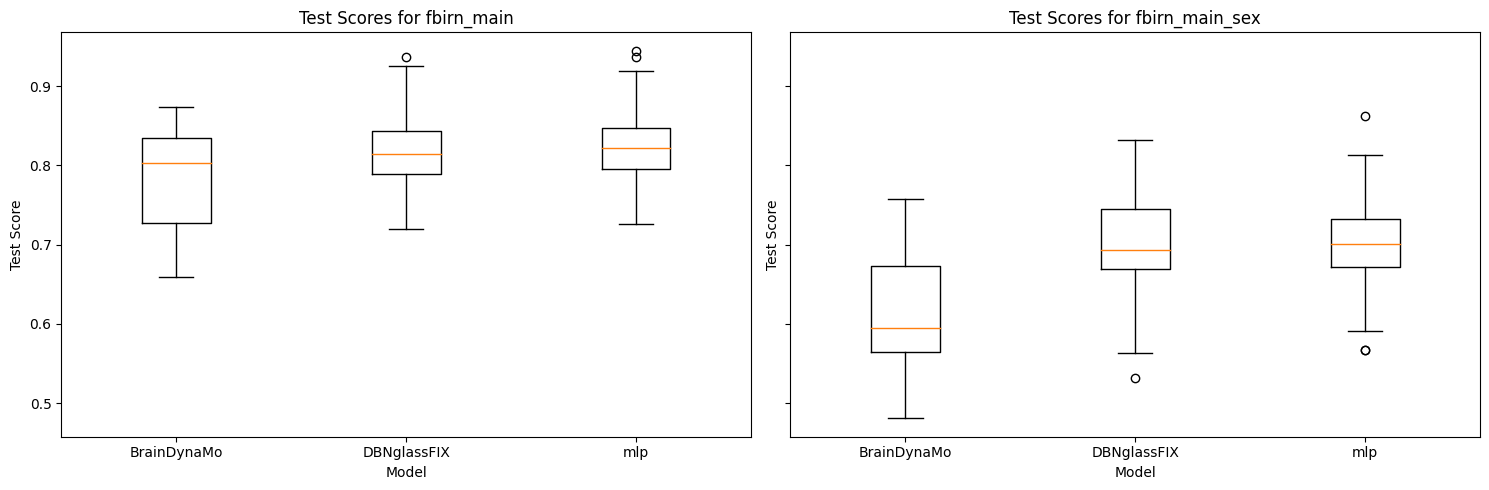

In [9]:
import matplotlib.pyplot as plt

# Prepare data for plotting
data_to_plot = {}
for dataset in datasets:
    data_to_plot[dataset] = []
    for model in models:
        data_to_plot[dataset].append(results[model][dataset]["test_score"])

# Plot boxplots
fig, axes = plt.subplots(1, len(datasets), figsize=(15, 5), sharey=True)
if len(datasets) == 1:
    axes = [axes]

for i, dataset in enumerate(datasets):
    axes[i].boxplot(data_to_plot[dataset], labels=models)
    axes[i].set_title(f"Test Scores for {dataset}")
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel("Test Score")

plt.tight_layout()
plt.show()

In [21]:
import torch
def load_torch_arrays(paths):
    arrays = []
    for path in paths:
        array = torch.load(path)
        arrays.append(array)
    return arrays

paths = []
paths_sex = []
for k in range(4):
    for trial in range(10):
        paths.append(f"/data/users2/ppopov1/glass_proj/assets/logs/_7_holdout-exp-BrainDynaMo-fbirn_main/k_{k:02d}/trial_{trial:04d}/data/fbirn_holdout_time_logits.pt")
        paths_sex.append(f"/data/users2/ppopov1/glass_proj/assets/logs/_7_holdout-exp-BrainDynaMo-fbirn_main_sex/k_{k:02d}/trial_{trial:04d}/data/fbirn_holdout_sex_time_logits.pt")
        # paths.append(f"/data/users2/ppopov1/glass_proj/assets/logs/_7_holdout-exp-BrainDynaMo-fbirn_main/k_{k:02d}/trial_{trial:04d}/data/fbirn_holdout_FNCs.pt")
        # paths_sex.append(f"/data/users2/ppopov1/glass_proj/assets/logs/_7_holdout-exp-BrainDynaMo-fbirn_main_sex/k_{k:02d}/trial_{trial:04d}/data/fbirn_holdout_sex_FNCs.pt")

arrays = load_torch_arrays(paths)
arrays_sex = load_torch_arrays(paths_sex)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Plot all the lines
plt.figure(figsize=(10, 6))
for i, array in enumerate(arrays):
    for j in range(array.shape[0]):
        plt.plot(array[j, :, 0].cpu().numpy(), label=f'class 0', alpha=0.5)
        plt.plot(array[j, :, 1].cpu().numpy(), label=f'class 1', alpha=0.5)

plt.xlabel('Points')
plt.ylabel('Values')
plt.title('All Data Plots')
plt.legend()
plt.show()


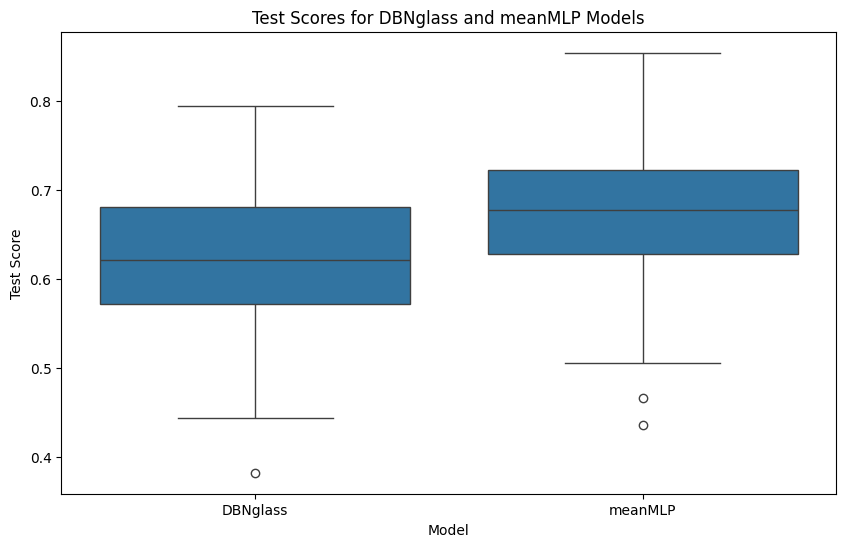

In [ ]:
# meanMLP performance on FBIRN sex

import seaborn as sns

data = pd.read_csv("/data/users2/ppopov1/glass_proj/assets/logs/_3_sex_0-exp-DBNglassFIX-fbirn_sex/runs.csv")
mlp_data = pd.read_csv("/data/users2/ppopov1/glass_proj/assets/logs/_3_sex_mlp-exp-mlp-fbirn_sex/runs.csv")

merged_data = pd.concat([data.assign(model='DBNglass'), mlp_data.assign(model='meanMLP')])

# Plot boxplots of "test_score" for each model
plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='test_score', data=merged_data)
plt.title('Test Scores for DBNglass and meanMLP Models')
plt.xlabel('Model')
plt.ylabel('Test Score')
plt.show()

In [12]:
data

training_time  test_accuracy  test_score  test_average_loss  \
0       99.982172       0.682540    0.539535           1.619292   
1       42.502427       0.682540    0.477907           1.598459   
2       61.785907       0.682540    0.468605           1.612612   
3       63.680057       0.682540    0.444186           1.607394   
4      130.219505       0.650794    0.619767           1.608909   
5      120.814781       0.666667    0.672093           1.552794   
6      104.178412       0.666667    0.500000           1.625381   
7       94.989805       0.682540    0.560465           1.626633   
8      134.667891       0.650794    0.570930           1.647437   
9      107.344157       0.682540    0.551163           1.619813   
10     109.295162       0.822581    0.739583           1.454716   
11     112.430179       0.790323    0.738095           1.439415   
12     109.175032       0.806452    0.699405           1.465906   
13      75.869393       0.774194    0.772321           1.489420   
14     110.349056       0.806452    0.794643           1.421541   
15     122.485334       0.774194    0.751488           1.436628   
16     107.224662       0.774194    0.730655           1.462616   
17      71.914622       0.774194    0.720238           1.490777   
18     122.009872       0.822581    0.738095           1.437452   
19      33.056087       0.774194    0.382440           1.606024   
20      78.014184       0.693548    0.727050           1.576942   
21     116.322430       0.709677    0.692778           1.573361   
22     135.927096       0.677419    0.656059           1.661437   
23     128.811611       0.709677    0.636475           1.603127   
24     129.570476       0.677419    0.631579           1.609748   
25     121.986385       0.693548    0.603427           1.601488   
26      91.730014       0.693548    0.675643           1.594514   
27     124.398013       0.709677    0.694002           1.623877   
28     118.740862       0.709677    0.642595           1.583508   
29     111.058396       0.709677    0.627907           1.578792   
30     114.352489       0.806452    0.590774           1.523808   
31      62.271235       0.774194    0.605655           1.505145   
32      64.519185       0.774194    0.544643           1.509503   
33     100.938073       0.774194    0.556548           1.504255   
34     144.858730       0.774194    0.683036           1.484878   
35     100.258958       0.774194    0.471726           1.526669   
36      81.683290       0.774194    0.613095           1.494236   
37     107.696839       0.806452    0.651786           1.467703   
38     139.986176       0.758065    0.599702           1.535651   
39     136.807417       0.758065    0.610119           1.536673   
40     129.491154       0.758065    0.574405           1.578620   
41      53.092485       0.774194    0.575893           1.525975   
42     112.925277       0.790323    0.592262           1.528051   
43     153.467505       0.741935    0.623512           1.597016   
44     141.745624       0.758065    0.616071           1.554011   
45     122.542274       0.758065    0.622024           1.530580   
46     163.211037       0.725806    0.608631           1.655795   
47      55.092392       0.774194    0.549107           1.518529   
48     105.960871       0.822581    0.629464           1.495322   
49     135.324517       0.758065    0.642857           1.514911   

    test_average_ce_loss  test_average_sp_loss  test_average_pred_loss  \
0               0.670900              0.177483                0.770909   
1               0.636159              0.190483                0.771817   
2               0.660696              0.176062                0.775853   
3               0.656154              0.175698                0.775543   
4               0.657203              0.180609                0.771096   
5               0.596738              0.183692                0.772364   
6               0.676475              0.178845                0.7700

# find the best model and analyze the attractors

In [33]:
# best models

models, model_names, attractors = [], [], []

dataset = "fbirn_main"

models = [f"/data/users2/ppopov1/glass_proj/assets/logs/__glassDBN_7-exp-DBNglassFIX-{dataset}/",
          f"/data/users2/ppopov1/glass_proj/assets/logs/__BDM_2-exp-BrainDynaMo-{dataset}/",
          f"/data/users2/ppopov1/glass_proj/assets/logs/__glassDBN_no_pretrain-exp-DBNglassFIX-{dataset}/",
          f"/data/users2/ppopov1/glass_proj/assets/logs/__BDM_no_pretrain-exp-BrainDynaMo-{dataset}/",
          ]
model_names = ["Best glassDBN (7)", "Best BrainDynaMo (2)", "scratch glassDBN", "scratch BrainDynaMo"]
attractors = [0, 0, 2, 2]

# score_to_load = "fbirn_holdout_score" if dataset == "fbirn_main" else "fbirn_holdout_sex_score"
score_to_load = "test_score"

data = []
for i, path in enumerate(models):
    results = pd.read_csv(f"{path}/runs.csv")
    data.append({
        "Name": model_names[i],
        "Scores": results[score_to_load],
        "Mean score": results[score_to_load].mean(),
        'Median score': results[score_to_load].median(),
        "Path": f"{path}/k_03/trial_0000/data/fbirn_holdout_time_FNCs.png",
        "Attractor": attractors[i],
    })

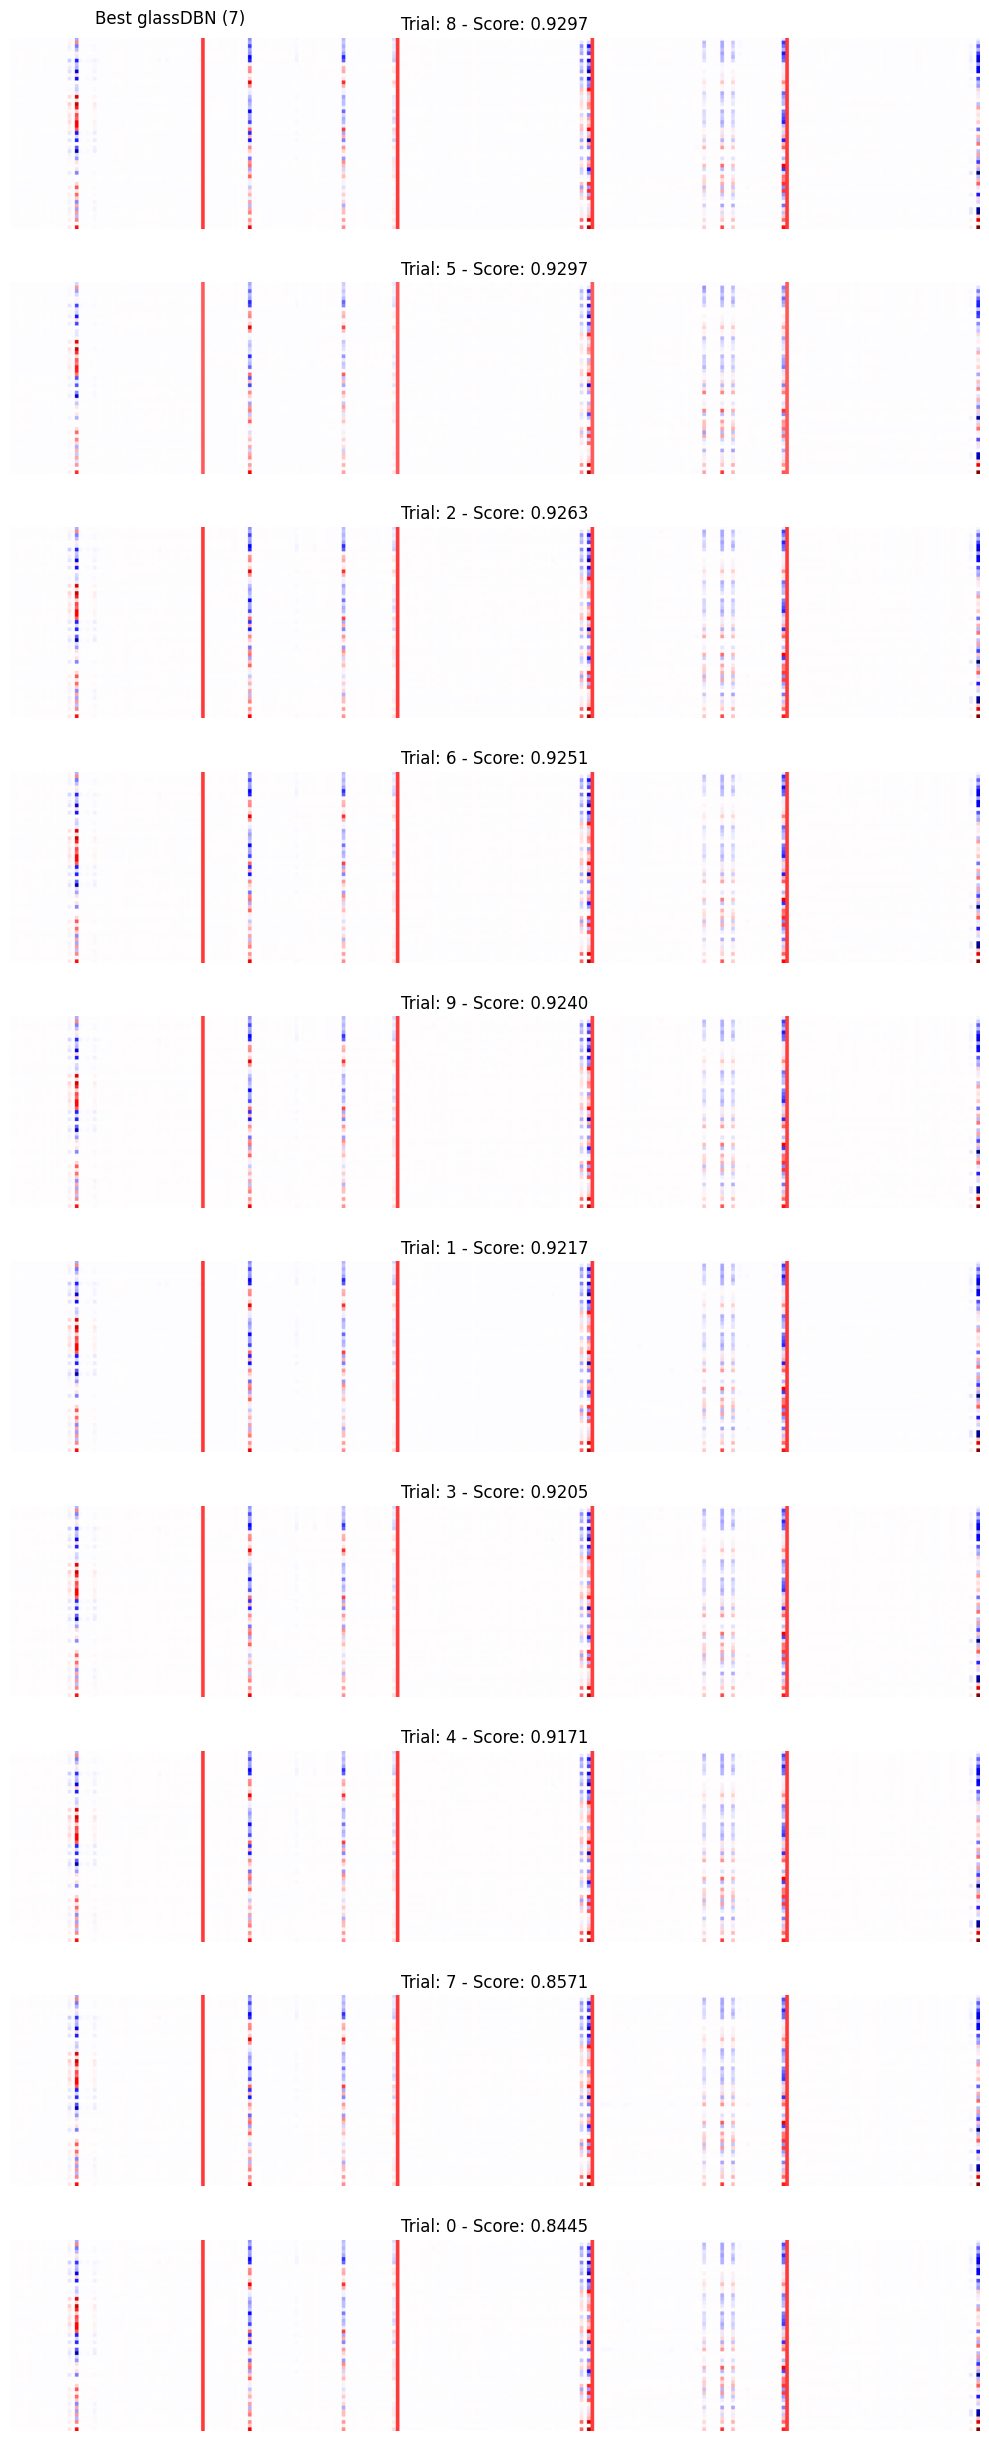

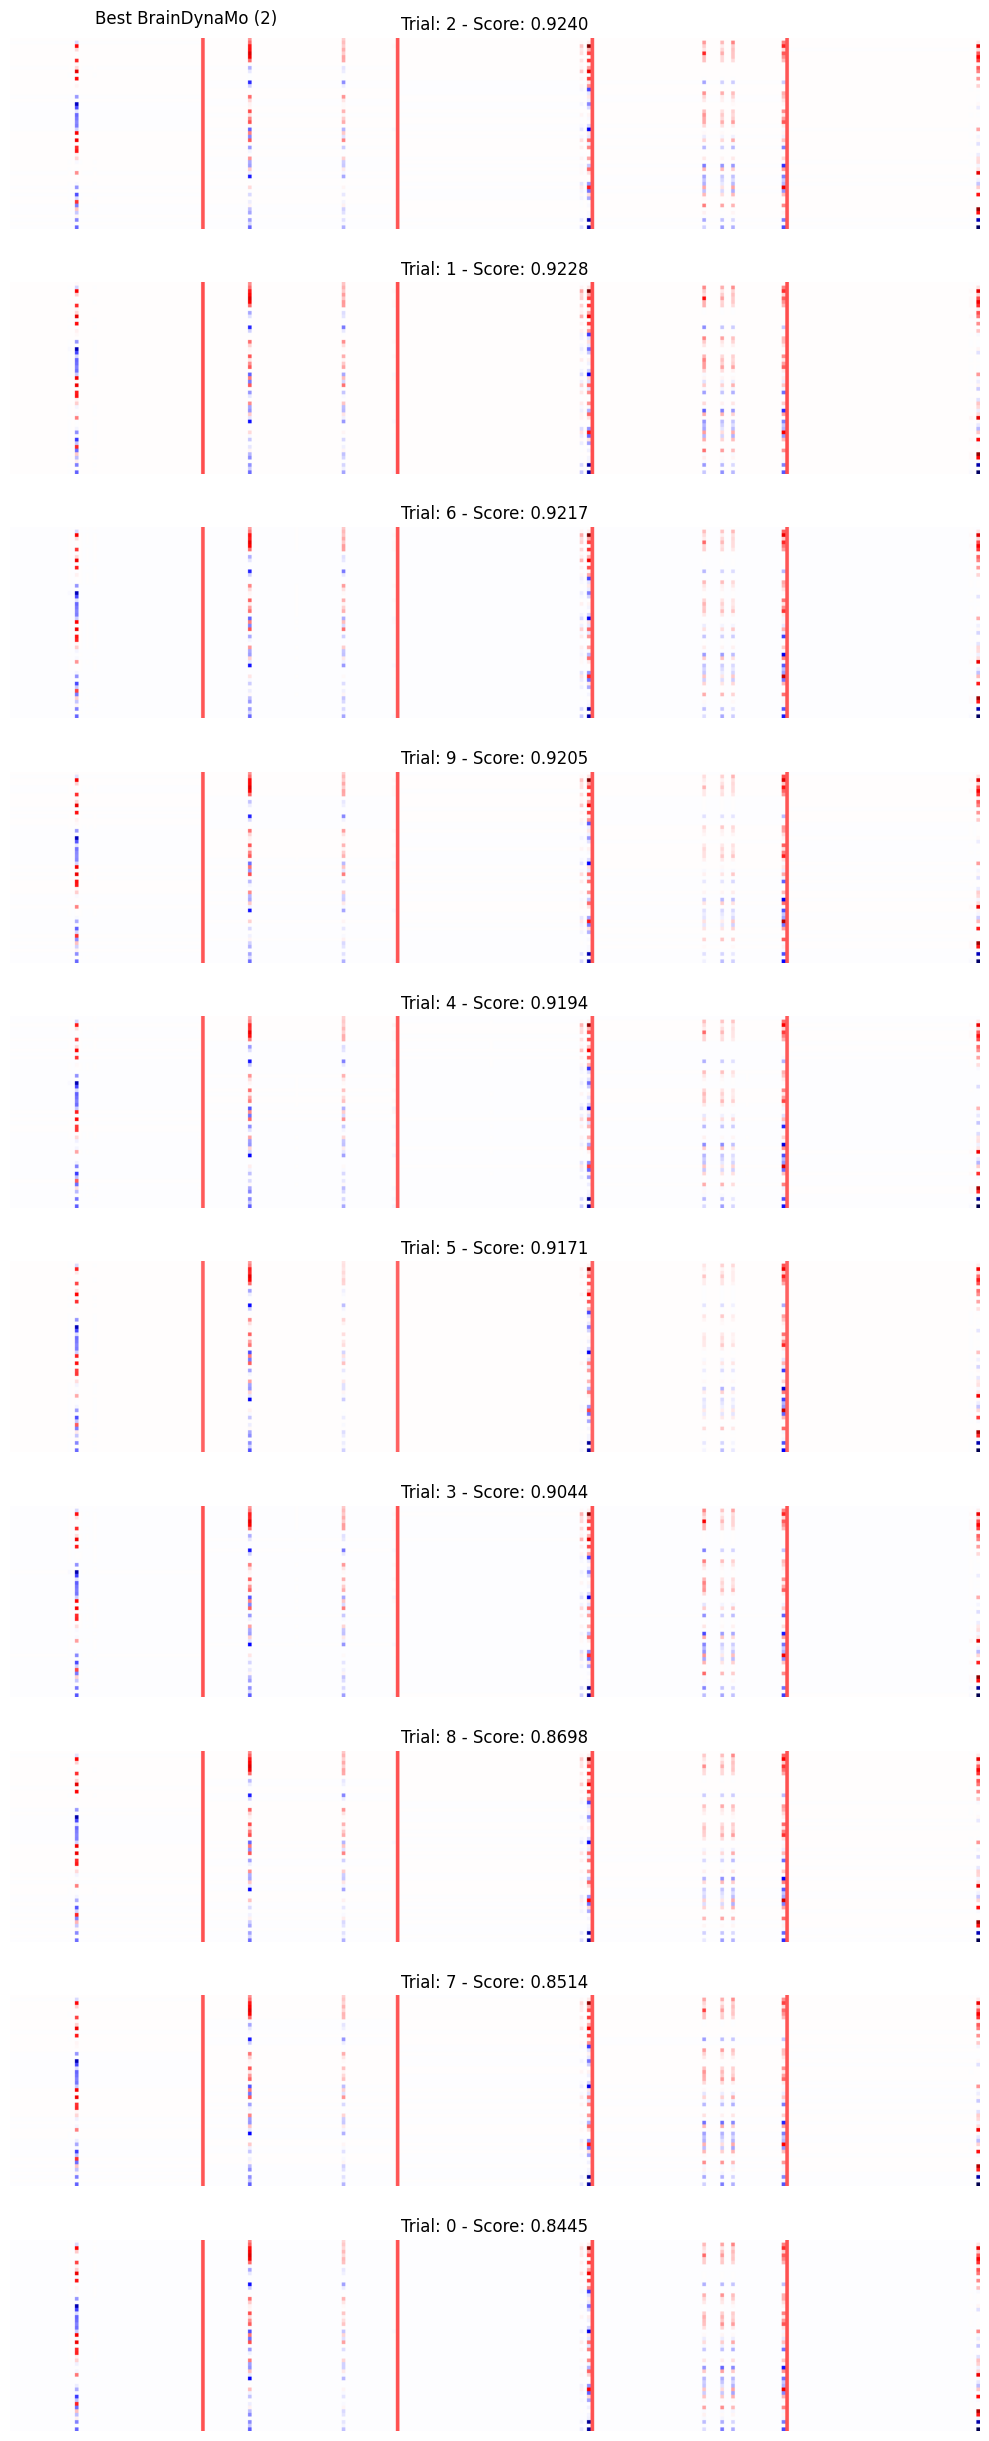

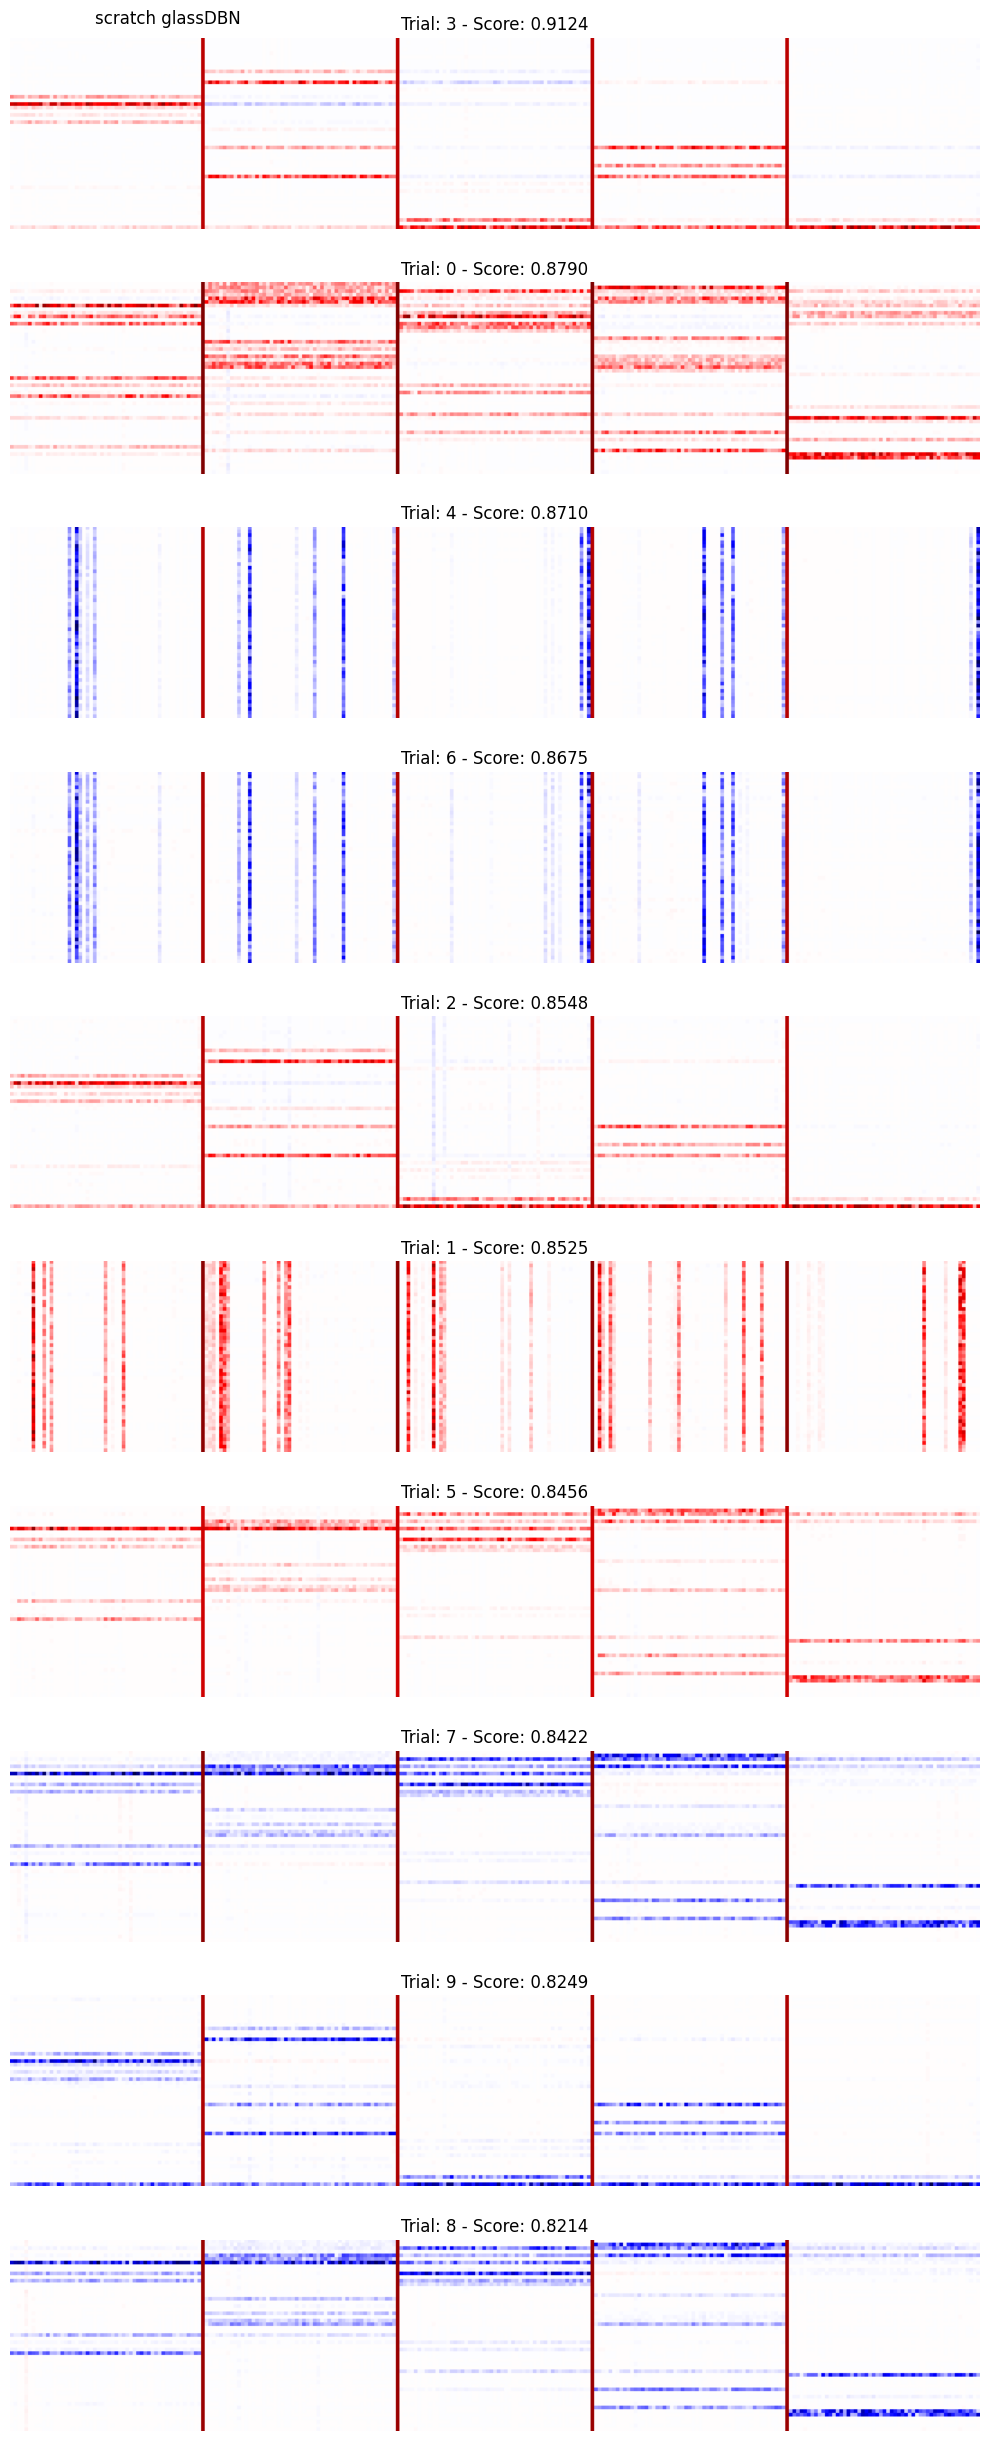

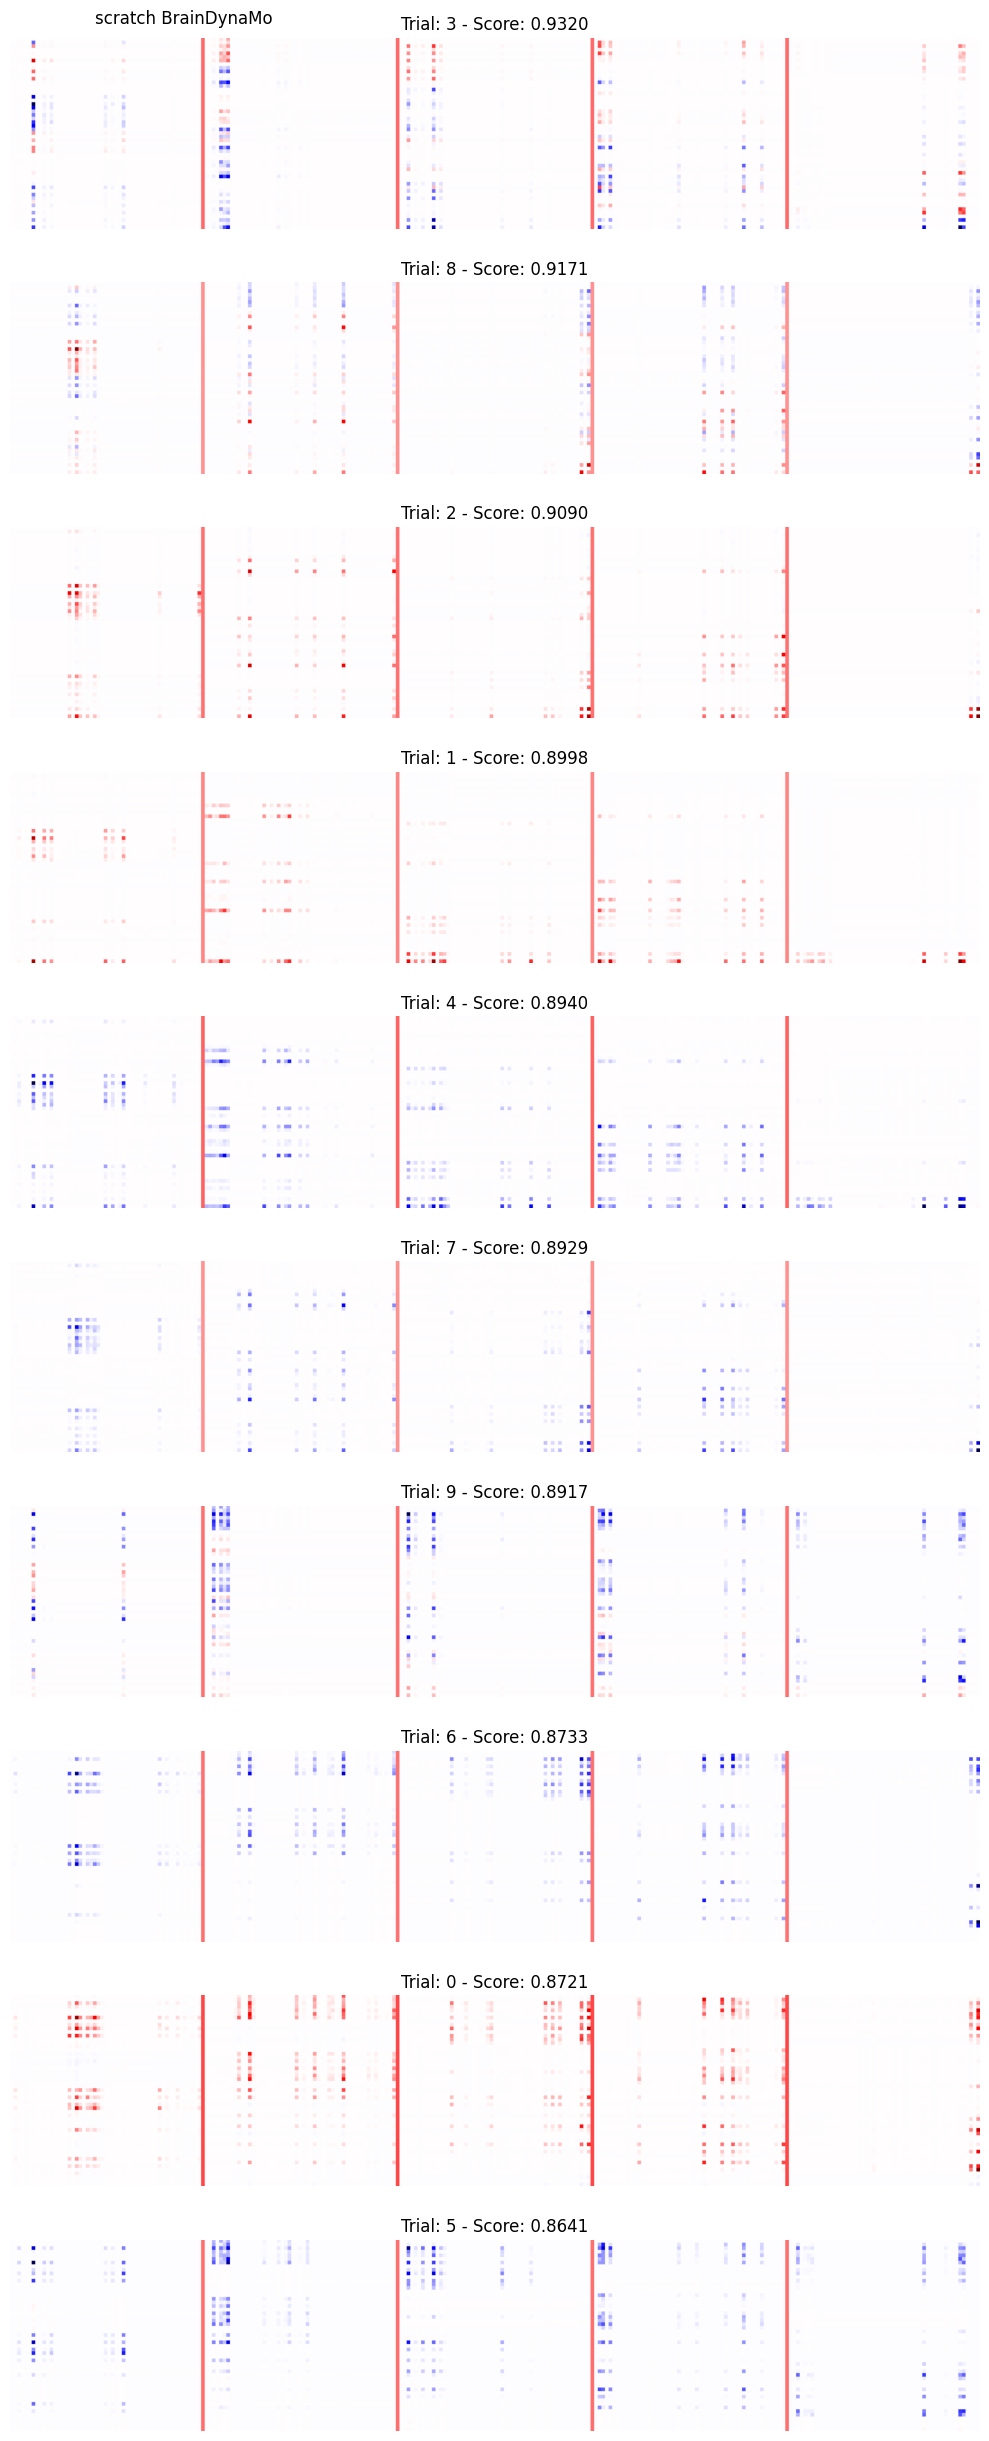

In [47]:
# analyze the matrices of models trained from scratch
import matplotlib.image as mpimg

paths = [
        f"/data/users2/ppopov1/glass_proj/assets/logs/__glassDBN_7-exp-DBNglassFIX-{dataset}/k_03/",
        f"/data/users2/ppopov1/glass_proj/assets/logs/__BDM_2-exp-BrainDynaMo-{dataset}/k_03/",
        f"/data/users2/ppopov1/glass_proj/assets/logs/__glassDBN_no_pretrain-exp-DBNglassFIX-{dataset}/k_03/",
        f"/data/users2/ppopov1/glass_proj/assets/logs/__BDM_no_pretrain-exp-BrainDynaMo-{dataset}/k_03/",
]

for path in paths: 
    scores = []
    image_paths = []

    for i in range(10):
        path_to_trial = f"{path}/trial_{i:04d}/"
        score = pd.read_csv(f"{path_to_trial}/test_log.csv")["test_score"].item()

        scores.append(score)

        image_paths.append(f"{path_to_trial}/data/fbirn_holdout_time_FNCs.png")

    scores = np.array(scores)
    sorted_indices = np.argsort(scores)[::-1]

    fig, axes = plt.subplots(len(sorted_indices), 1, figsize=(10, len(sorted_indices) * 2.5))


    for i, idx in enumerate(sorted_indices):
        img = mpimg.imread(image_paths[idx])
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Trial: {idx} - Score: {scores[idx]:.4f}")
        
    fig.suptitle(model_names[paths.index(path)], fontsize=12, x=0.1, ha='left')
    # fig.suptitle(model_names[paths.index(path)], fontsize=12)
    fig.tight_layout()
    fig.show()
    

In [29]:
models, model_names, attractors = [], [], []

# dataset = "fbirn_main_sex"
dataset = "fbirn_main"

# models = [f"/data/users2/ppopov1/glass_proj/assets/logs/__glassDBN_{i}-exp-DBNglassFIX-{dataset}/" for i in range(21)]
# model_names = [f"DBN {i}" for i in range(20)] + ["DBN"]
# attractors = [0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]

models += [f"/data/users2/ppopov1/glass_proj/assets/logs/__BDM_{i}-exp-BrainDynaMo-{dataset}/" for i in range(6)]
model_names += [f"BDM {i}" for i in range(6)]
attractors += [0, 1, 0, 1, 1, 1]

# models += [f"/data/users2/ppopov1/glass_proj/assets/logs/__glassDBN_no_pretrain-exp-DBNglassFIX-{dataset}/"]
# model_names += ["DBN w/o pt"]
# attractors += [2]

# models += [f"/data/users2/ppopov1/glass_proj/assets/logs/__BDM_no_pretrain-exp-BrainDynaMo-{dataset}/"]
# model_names += ["BDM w/o pt"]
# attractors += [2]

# score_to_load = "fbirn_holdout_score" if dataset == "fbirn_main" else "fbirn_holdout_sex_score"
score_to_load = "test_score"

data = []
for i, path in enumerate(models):
    results = pd.read_csv(f"{path}/runs.csv")
    data.append({
        "Name": model_names[i],
        "Scores": results[score_to_load],
        "Mean score": results[score_to_load].mean(),
        'Median score': results[score_to_load].median(),
        "Path": f"{path}/k_03/trial_0000/data/fbirn_holdout_time_FNCs.png",
        "Attractor": attractors[i],
    })

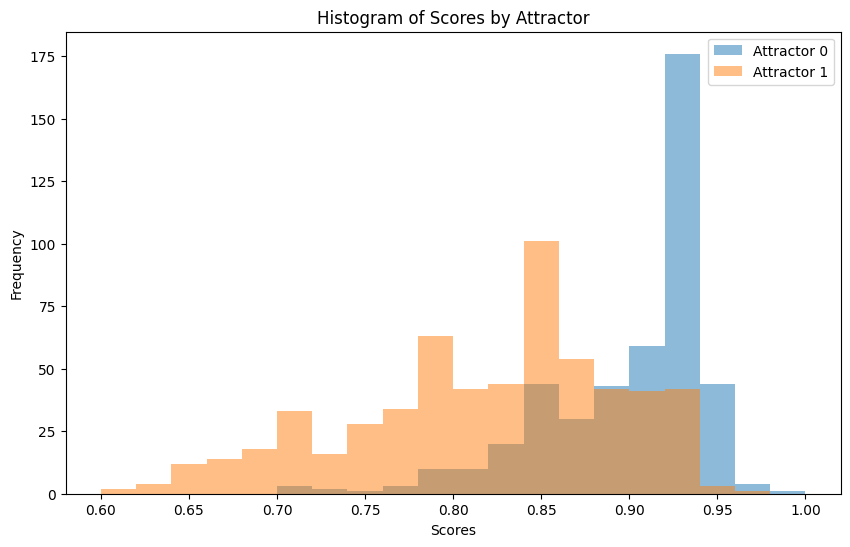

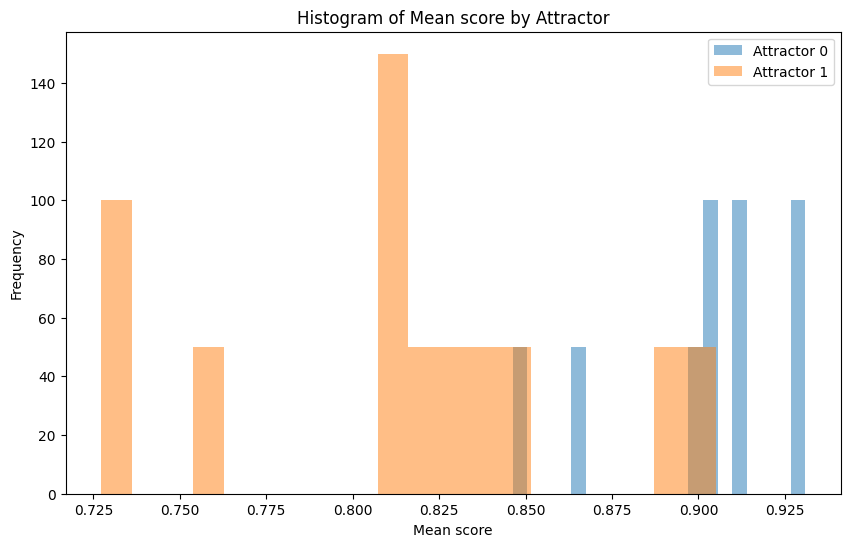

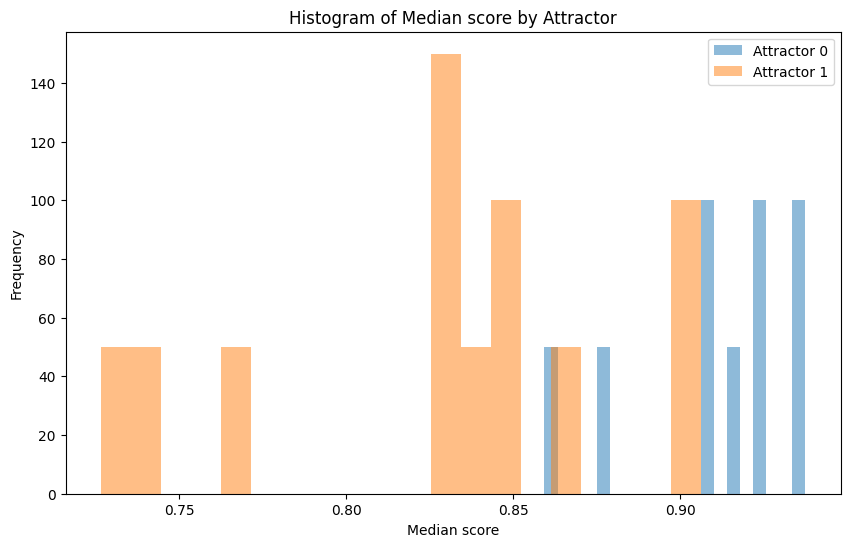

In [12]:
# histogram

import pandas as pd
import matplotlib.pyplot as plt

score_to_plot = "Scores"
score_to_plot = "Mean score"
score_to_plot = "Median score"

plots = ["Scores", "Mean score", "Median score"]
# plots = ["Scores"]

expanded_data = []
for item in data:
    if item["Attractor"] == 2:
        continue
    for score in item["Scores"]:
        expanded_data.append({
            "Name": item["Name"],
            "Scores": score,
            "Mean score": item["Mean score"],
            'Median score': item["Median score"],
            "Attractor": item["Attractor"],
            "Path": item["Path"]
        })

df = pd.DataFrame(expanded_data)

scores = {}
for score_to_plot in plots:
    scores[score_to_plot] = {}
    # Plot histograms using matplotlib
    plt.figure(figsize=(10, 6))

    # Plot histograms for each attractor
    # sns.histplot(data=df, x=score_to_plot, hue="Attractor", multiple="dodge", palette="Set1", kde=True)
    for attractor in df["Attractor"].unique():
        subset = df[df["Attractor"] == attractor]
        scores[score_to_plot][attractor] = list(subset[score_to_plot])

        plt.hist(subset[score_to_plot], 
                 range=[0.6, 1] if score_to_plot == "Scores" else None, 
                 bins=20, 
                 alpha=0.5, 
                 label=f"Attractor {attractor}"
                 )


    plt.xlabel(f"{score_to_plot}")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Histogram of {score_to_plot} by Attractor")
    plt.show()


In [16]:
attractor_0 = scores["Scores"][0]
attractor_1 = scores["Scores"][1]

import numpy as np
from scipy import stats


# 1. Welch's t-test
t_stat, p_value_welch = stats.ttest_ind(attractor_0, attractor_1, equal_var=False)
print(f"Welch's t-test: t-statistic = {t_stat:.4f}, p-value = {p_value_welch}")

# 2. Mann-Whitney U test (Wilcoxon rank-sum test)
u_stat, p_value_mannwhitney = stats.mannwhitneyu(attractor_0, attractor_1, alternative='two-sided')
print(f"Mann-Whitney U test: U-statistic = {u_stat:.4f}, p-value = {p_value_mannwhitney}")

# 3. Bootstrap test for difference in means
def bootstrap_test(group1, group2, n_bootstrap=10000):
    # Observed difference in means
    observed_diff = np.mean(group1) - np.mean(group2)
    
    # Combined data
    combined = np.concatenate([group1, group2])
    
    # Bootstrap resampling
    bootstrap_diffs = []
    for _ in range(n_bootstrap):
        # Resample with replacement
        resample = np.random.choice(combined, size=len(combined), replace=True)
        resample1 = resample[:len(group1)]
        resample2 = resample[len(group1):]
        bootstrap_diffs.append(np.mean(resample1) - np.mean(resample2))
    
    # Calculate p-value as the proportion of bootstrap differences >= observed difference
    p_value = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))
    return observed_diff, p_value

observed_diff, p_value_bootstrap = bootstrap_test(attractor_0, attractor_1)
print(f"Bootstrap test: Observed difference = {observed_diff}, p-value = {p_value_bootstrap}")

Welch's t-test: t-statistic = 21.5076, p-value = 1.5870165383739288e-84
Mann-Whitney U test: U-statistic = 224718.5000, p-value = 1.99777586579726e-76
Bootstrap test: Observed difference = 0.08380208333333339, p-value = 0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


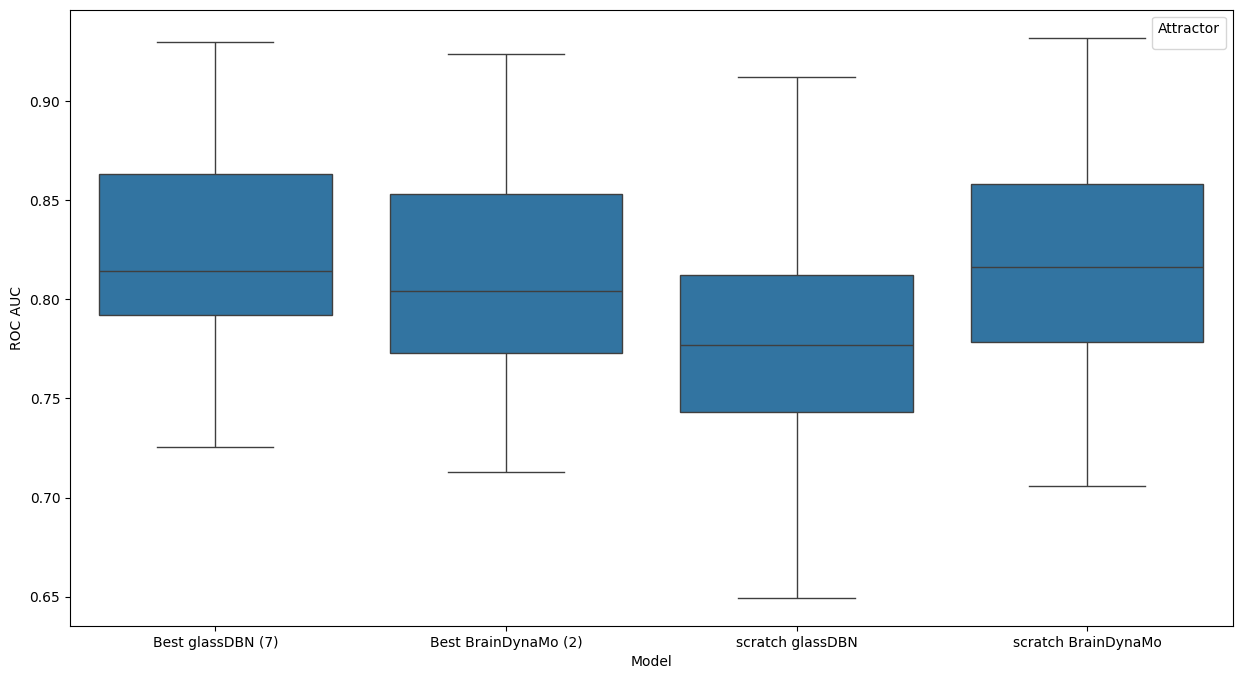

In [ ]:
# boxplots

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sorting_score = "Mean"
sorting_score = "Median"

# Sort data by mean_score
sorted_data = sorted(data, key=lambda x: x[f'{sorting_score} score'], reverse=True)
sorted_data = data

# Extract names and scores for plotting
names = [item['Name'] for item in sorted_data]
scores = [item['Scores'] for item in sorted_data]
attractors = [item['Attractor'] for item in sorted_data]

# Create a DataFrame for plotting with attractors
df = pd.DataFrame(scores).T
df.columns = names
df = df.melt(var_name='Model', value_name='Score')
df['Attractor'] = df['Model'].apply(lambda x: attractors[names.index(x)])

# Plot the boxplots with colors based on attractors
plt.figure(figsize=(15, 8))
# box = sns.boxplot(x='Model', y='Score', hue='Attractor', data=df, palette={0: 'blue', 1: 'orange', 2: 'red',})
box = sns.boxplot(x='Model', y='Score', data=df)

plt.xticks()
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('Scores Boxplot Sorted by Mean Score')
plt.legend(title='Attractor')
plt.show()

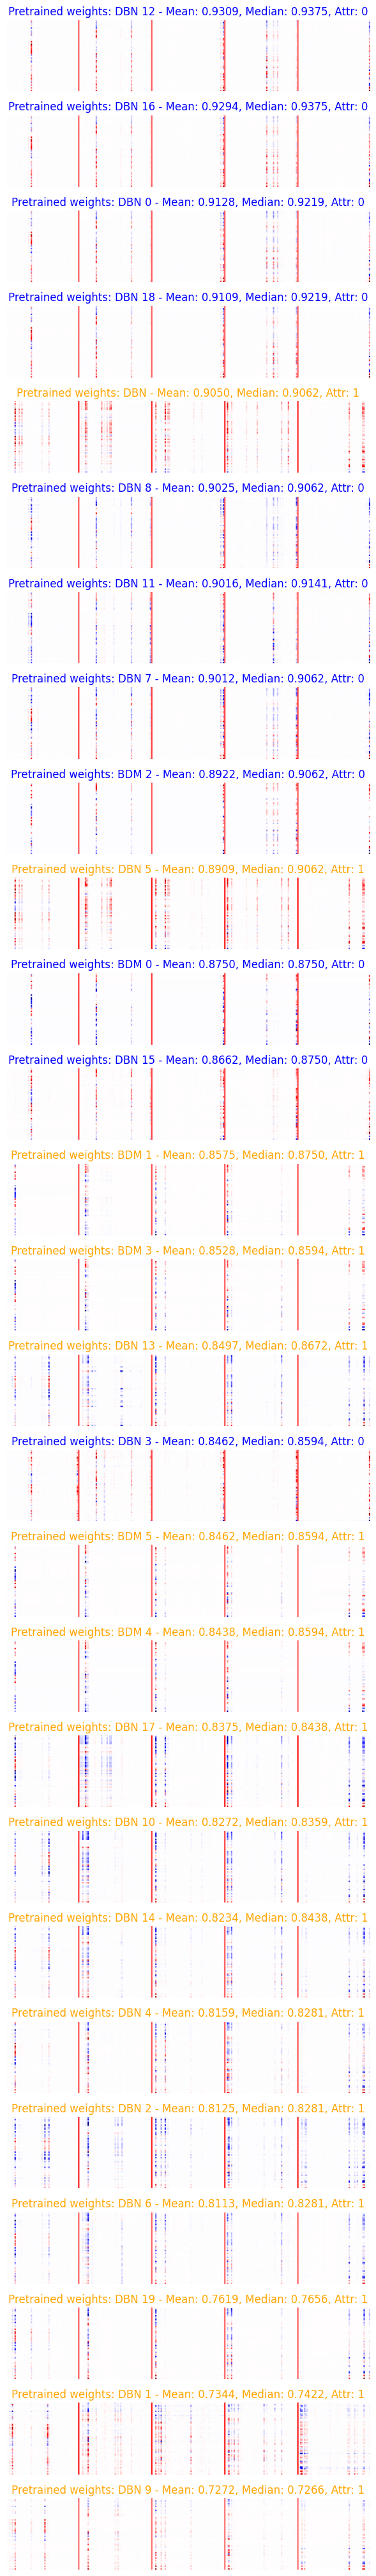

In [152]:
# plot matrices sorted according to the mean AUC

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Sort data by mean_score
sorted_data = data
sorted_data = sorted(data, key=lambda x: x['Median score'], reverse=True)
sorted_data = sorted(data, key=lambda x: x['Mean score'], reverse=True)

# Plot the images sorted by mean score
fig, axes = plt.subplots(len(sorted_data), 1, figsize=(8, len(sorted_data)*1.5))

for i, item in enumerate(sorted_data):
    img = mpimg.imread(item['Path'])
    axes[i].imshow(img)
    axes[i].axis('off')
    # axes[i].set_title(f"Pretrained weights: {item['Name']} - Mean: {item['Mean score']:.4f}, Median: {item['Median score']:.4f}, Attr: {item['Attractor']}")
    color = 'blue' if item['Attractor'] == 0 else 'orange'
    axes[i].set_title(f"Pretrained weights: {item['Name']} - Mean: {item['Mean score']:.4f}, Median: {item['Median score']:.4f}, Attr: {item['Attractor']}", color=color)

plt.tight_layout()
plt.show()